## Volatility Forecasting

Prediciting short term volatility forecasting between 1 to 5-days forecast and comparing between traditional models with deep learning models

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

from scipy import stats

In [4]:
spy_data = yf.download(["^GSPC"],start="2005-01-01", auto_adjust = False)["Adj Close"]

[*********************100%***********************]  1 of 1 completed


In [5]:
spy_data = spy_data.rename(columns={"^GSPC":"S&P500"})

In [6]:
spy_data.head()

Ticker,S&P500
Date,
2005-01-03,1202.079956
2005-01-04,1188.050049
2005-01-05,1183.739990
2005-01-06,1187.890015
2005-01-07,1186.189941


In [7]:
# Loading the VIX data for reference
vix = yf.Ticker("^VIX")
vix_data = vix.history(start="2005-01-01")
vix_data.reset_index(inplace=True)

In [8]:
vix_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2005-01-03 00:00:00-06:00,13.39,14.23,13.25,14.08,0,0.0,0.0
1,2005-01-04 00:00:00-06:00,14.01,14.45,13.93,13.98,0,0.0,0.0
2,2005-01-05 00:00:00-06:00,13.98,14.09,13.26,14.09,0,0.0,0.0
3,2005-01-06 00:00:00-06:00,14.09,14.09,13.33,13.58,0,0.0,0.0
4,2005-01-07 00:00:00-06:00,13.47,13.51,12.94,13.49,0,0.0,0.0


For ETFs like SPY the close and adjusted close are usually small and since this project is concerned with modelling volatility and not price return we would stick to using the Close as a parameter

In [10]:
len(spy_data)

5259

In [11]:
spy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5259 entries, 2005-01-03 to 2025-11-25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   S&P500  5259 non-null   float64
dtypes: float64(1)
memory usage: 82.2 KB


In [12]:
spy_data.describe()

Ticker,S&P500
count,5259.000000
mean,2517.167459
std,1469.834021
min,676.530029
25%,1322.334961
50%,2046.680054
75%,3371.570068
max,6890.890137


##### Return Distribution

In [14]:
df_returns = (np.log(spy_data) - np.log(spy_data.shift(1))).dropna()

In [15]:
df_returns.head()

Ticker,S&P500
Date,
2005-01-04,-0.011740
2005-01-05,-0.003634
2005-01-06,0.003500
2005-01-07,-0.001432
2005-01-10,0.003417


In [16]:
np.mean(df_returns)

0.00032824397419277293

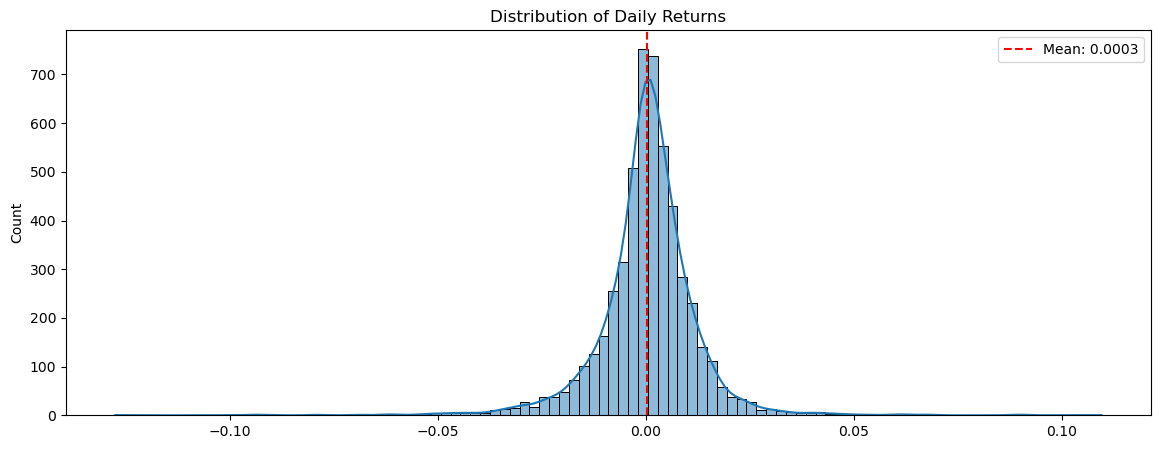

In [17]:
plt.figure(figsize=(14,5))
sns.histplot(df_returns, kde=True, bins=100)
plt.title("Distribution of Daily Returns")
plt.axvline(np.mean(df_returns), color="r", linestyle="--", label=f"Mean: {np.mean(df_returns):.4f}")
plt.legend()

In [18]:
from scipy.stats import jarque_bera

jb_stat, p_value = jarque_bera(df_returns)
print(f"Jarque-Bera p-value: {p_value:.8f}")  # p < 0.05 → Not normal

Jarque-Bera p-value: 0.00000000


In [19]:
print(f"Skewness: {df_returns["S&P500"].skew():.4f}")  # Negative → Left tail
print(f"Excess Kurtosis: {df_returns["S&P500"].kurtosis()-3:.4f}")  # >3 → Fat tails

Skewness: -0.4766
Excess Kurtosis: 10.1812


The distribution of the S&P returns shows that it is not symmetric and moderately negatively skewed. This means that returns are moderately positive, but investors should be on the lookout for large losses (although they don't happen frequently) but more likely than large gains.
The excess kurtosis of 8.6875 indicates heavy tail - to the left in this case due to the presence of extreme values or outliers.
Due to these observations statistical methods that assume normality would not be appropriate for modeling or analysis

#### Range

In [22]:
spy = yf.Ticker("^GSPC")
spy_data = spy.history(start="2018-01-01", end="2024-12-31")
spy_data.reset_index(inplace=True)

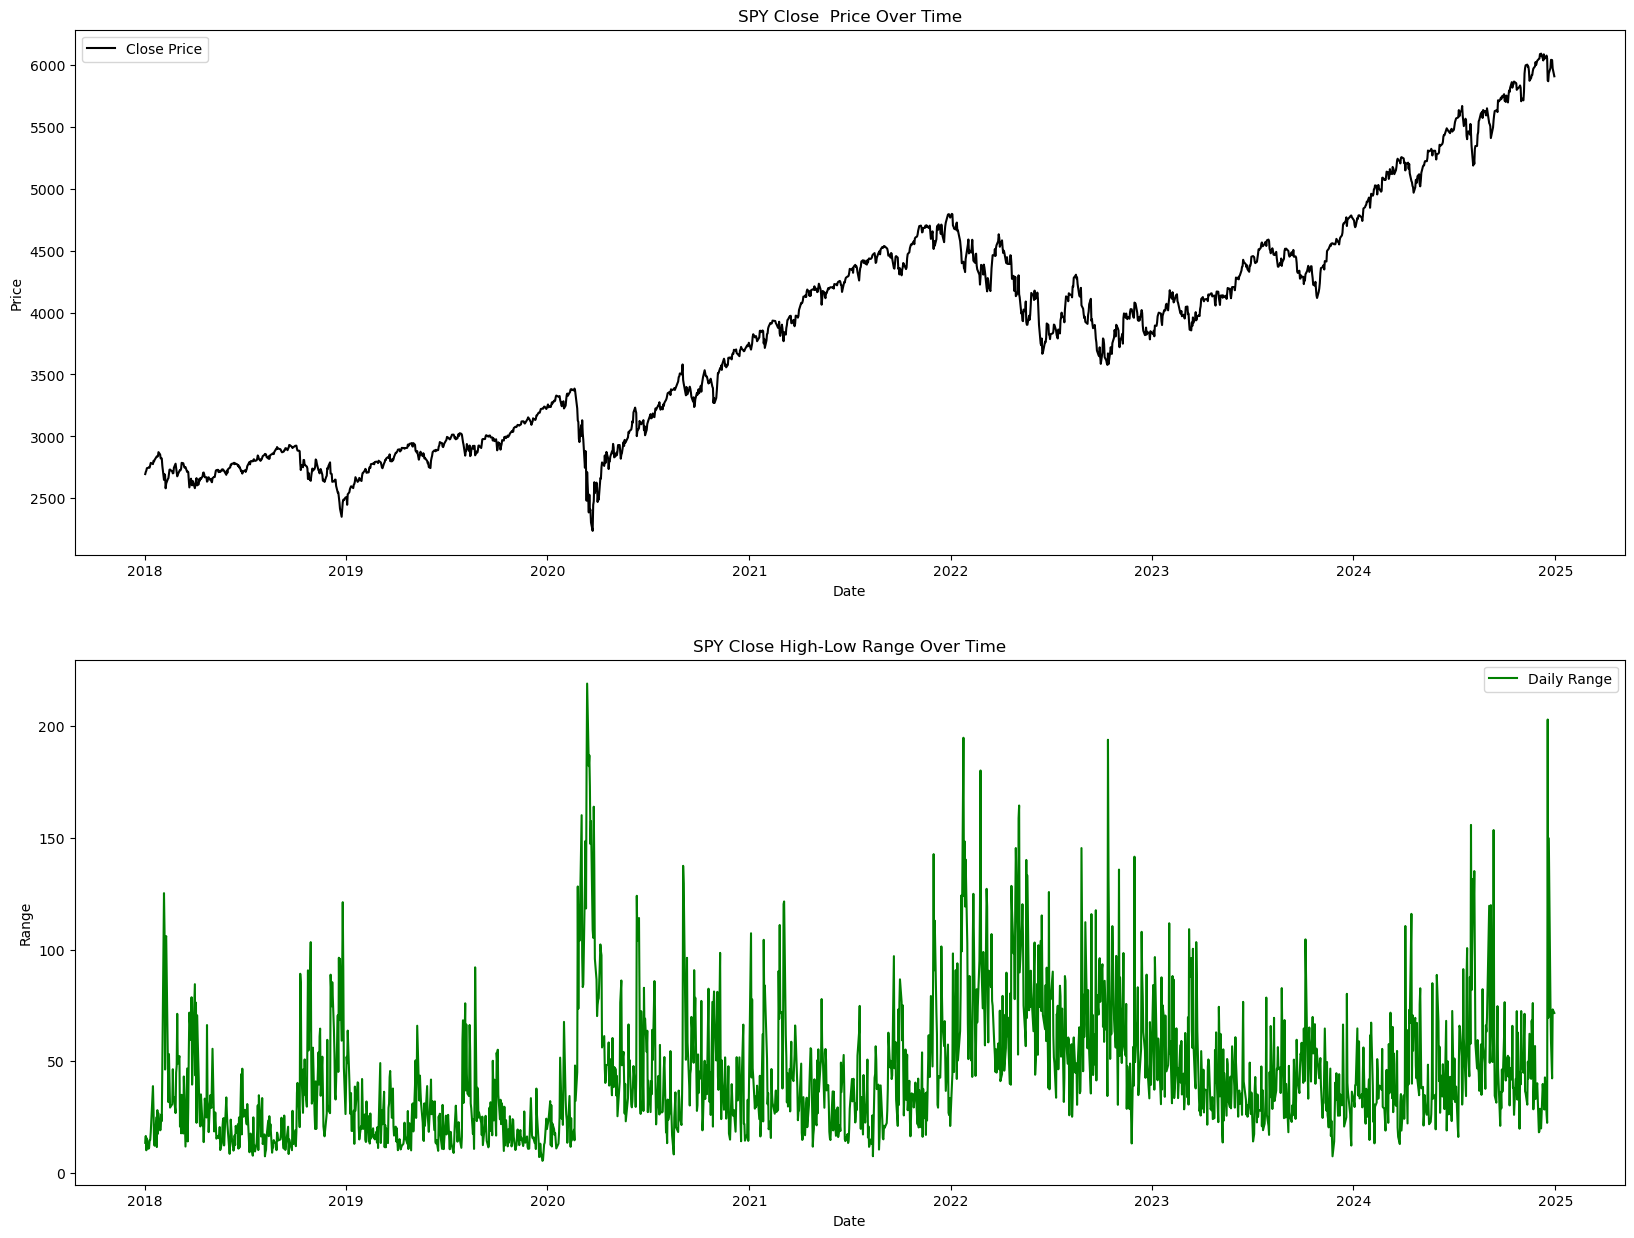

In [23]:
spy_data["Range"] = spy_data["High"] - spy_data["Low"]

fig, ax = plt.subplots(2,1, figsize=(20,15))
ax[0].plot(spy_data["Date"], spy_data["Close"], label="Close Price", color='black')
ax[0].set_title("SPY Close  Price Over Time")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")
ax[0].legend()

ax[1].plot(spy_data["Date"], spy_data["Range"], label="Daily Range", color="green")
ax[1].set_title("SPY Close High-Low Range Over Time")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Range")
ax[1].legend()


plt.show();



This trend shows that the SPY has been on a bullish trend since 2020 where there was the dip due to the Covid-19 pandemic, where we also notice a high range in price 

#### Volatility Clustering

In [26]:
from statsmodels.tsa.stattools import acf

In [27]:
from statsmodels.graphics.tsaplots import plot_acf

The autocorrelation function helps determine whether past volatility influences future volatility

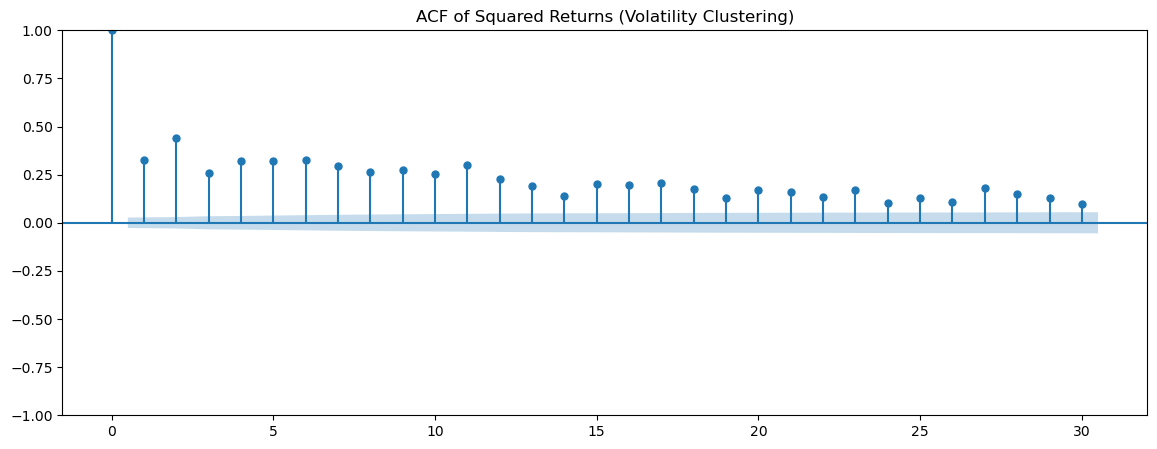

In [29]:
# Autocorrelation of squared returns
returns = df_returns["S&P500"]

fig, ax = plt.subplots(figsize=(14, 5)) 
plot_acf(returns**2, lags=30, alpha=0.05, title="ACF of Squared Returns (Volatility Clustering)", ax=ax) # Since volatility is unobserved r**2 is used not raw returns
plt.show()

This acf for understanding volatility cluster reveals that at most, volatility effects spills into at most 15days with its siginificant effect still visible in day 1 and 2. The 95% confidence interval boundary indicated by the blue shaded region shows that the volatility is in no longer statistically significant beween days 18 onwards.

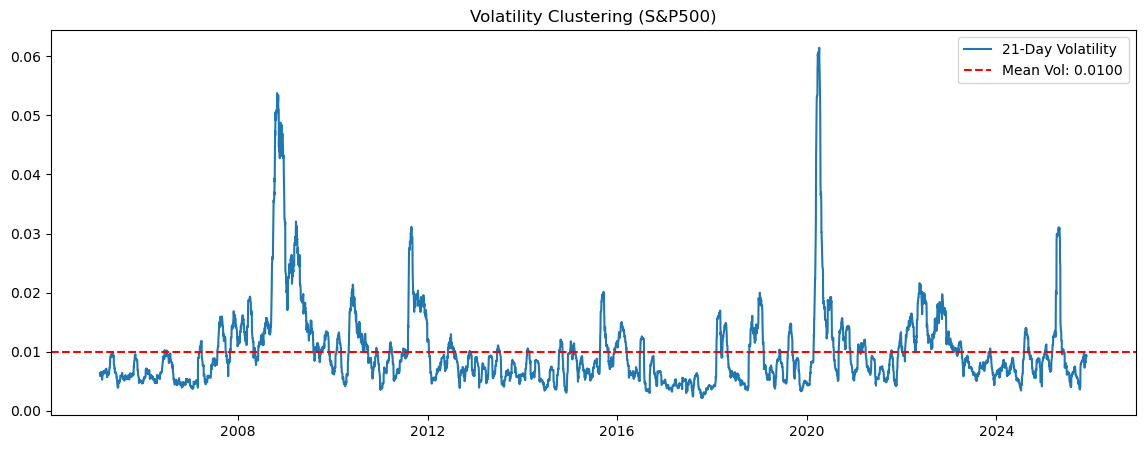

In [31]:
volatility = returns.rolling(21).std()

plt.figure(figsize=(14,5))
plt.plot(volatility.index, volatility, label="21-Day Volatility")
plt.title("Volatility Clustering (S&P500)")
plt.axhline(volatility.mean(), color='r', linestyle="--", label=f"Mean Vol: {volatility.mean():.4f}")
plt.legend()

#### Testing for Stationarity

This helps to determine if volatility changes around the mean significantly, highlighting moments in time when there was economic turbulence

In [34]:
from statsmodels.tsa.stattools import adfuller

In [35]:
def test_stationarity(series, name=None):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Value:")
    for k,v in result[4].items():
        print(f"{k}: {v:.4f}")

In [36]:
test_stationarity(returns, "Returns")

ADF Test for Returns
ADF Statistic: -16.2778
p-value: 0.0000
Critical Value:
1%: -3.4316
5%: -2.8621
10%: -2.5671


In [37]:
test_stationarity(volatility, "Volatility")

ADF Test for Volatility
ADF Statistic: -6.5415
p-value: 0.0000
Critical Value:
1%: -3.4316
5%: -2.8621
10%: -2.5671


The result of the stationarity test shows that the volatility series for the S&P 500 Index is fairly stationary (null hypothesis rejected) from the ADF score which is lesser than the critical values and also from the p value being less than 0.05. 

#### Regime Detection

In [40]:
from sklearn.cluster import KMeans

In [41]:
len(df_returns), len(df_returns["S&P500"])

(5258, 5258)

In [42]:
df_returns.head()

Ticker,S&P500
Date,
2005-01-04,-0.011740
2005-01-05,-0.003634
2005-01-06,0.003500
2005-01-07,-0.001432
2005-01-10,0.003417


In [43]:
df_returns["Volatility"] = df_returns["S&P500"].rolling(21).std() * np.sqrt(252) # Annualized
df_returns["Returns_MA"] = df_returns["S&P500"].rolling(21).mean() # Smooth returns

In [44]:
df_returns.describe()

Ticker,S&P500,Volatility,Returns_MA
count,5258.000000,5238.000000,5238.000000
mean,0.000328,0.158430,0.000333
std,0.012108,0.111430,0.002254
min,-0.127652,0.034688,-0.019047
25%,-0.004075,0.093446,-0.000581
50%,0.000730,0.129766,0.000673
75%,0.005706,0.186506,0.001603
max,0.109572,0.975552,0.010669


In [45]:
X = df_returns[["Volatility", "Returns_MA"]].dropna()
kmeans = KMeans(n_clusters=3, random_state=16)
X["Regime"] = kmeans.fit_predict(X[["Volatility", "Returns_MA"]])

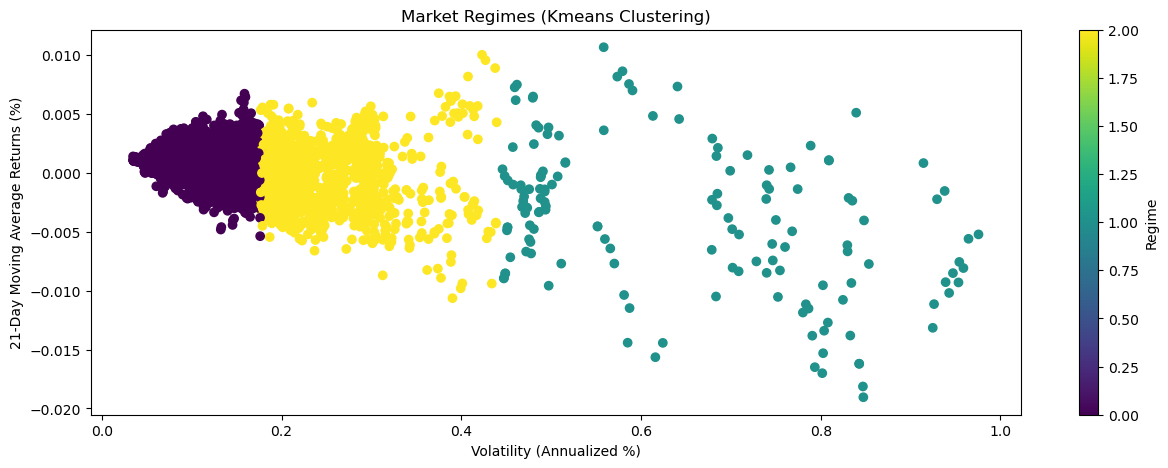

In [46]:
plt.figure(figsize=(15,5))
plt.scatter(X["Volatility"], X["Returns_MA"], c=X["Regime"], cmap="viridis")
plt.xlabel("Volatility (Annualized %)")
plt.ylabel("21-Day Moving Average Returns (%)")
plt.title("Market Regimes (Kmeans Clustering)")
plt.colorbar(label="Regime")
plt.show();

In [47]:
from sklearn.metrics import silhouette_score
print(f"Silhouette Score: {silhouette_score(X[['Volatility', 'Returns_MA']], X['Regime']):.2f}")

Silhouette Score: 0.64


In [48]:
# Better understand financial context of clustered regimes
centroids = kmeans.cluster_centers_
pd.DataFrame(centroids, columns = ["Volatility", "Returns_MA"], index=["Regime 0", "Regime 1", "Regime 2"])

,Volatility,Returns_MA
Regime 0,0.110022,0.000780
Regime 1,0.644976,-0.004008
Regime 2,0.242537,-0.000462


#### **Regime 0: "Choppy Markets"**  
- **Volatility**: `0.110` (Moderate)  
- **Returns**: `0.00078` (Neutral/Slightly Negative)  
- **Interpretation**:  
  - **Low-to-moderate volatility** with flat/negative returns.  
  - Typical of **sideways markets** or periods of uncertainty (e.g., Fed policy limbo).  

#### **Regime 2: "Bull Market"**  
- **Volatility**: `0.242` (Low)  
- **Returns**: `0.000462` (Positive)  
- **Interpretation**:  
  - **Low volatility + steady gains** → Classic *bull market* (e.g., 2017, 2019).  
  - Low risk, ideal for trend-following strategies.  

#### **Regime 1: "Crisis"**  
- **Volatility**: `0.645` (Very High)  
- **Returns**: `-0.004` (Strongly Negative)  
- **Interpretation**:  
  - **Extreme volatility + losses** → *Market crashes* (e.g., COVID-19, 2008).  
  - High-risk regime; avoid leverage and hedge aggressively.

In [50]:
X.reset_index(inplace=True)

In [51]:
crisis_date = "2019-11-01"
X[X["Date"]>=crisis_date]["Regime"].value_counts()

Regime
0    1025
2     449
1      51
Name: count, dtype: int64

### Feature Engineering

In [53]:
df_returns.head()

Ticker,S&P500,Volatility,Returns_MA
Date,,,
2005-01-04,-0.011740,NaN,NaN
2005-01-05,-0.003634,NaN,NaN
2005-01-06,0.003500,NaN,NaN
2005-01-07,-0.001432,NaN,NaN
2005-01-10,0.003417,NaN,NaN


#### Lagged Features

In [55]:
# Lagged returns and volatility (1, 5, 21 days)
for lag in [1, 5, 21]:
    df_returns[f"Return_Lag_{lag}"] = df_returns["S&P500"].shift(lag)
    df_returns[f"Volatility_Lag_{lag}"] = df_returns["Volatility"].shift(lag)

#### Rolling Statistics

In [57]:
# Rolling extremes
df_returns["Rolling_Min_21"] = df_returns["S&P500"].rolling(21).min()
df_returns["Rolling_Max_21"] = df_returns["S&P500"].rolling(21).max()

# Rolling volatility rations
df_returns["Volatility_Ratio_5_21"] = (
    df_returns["S&P500"].rolling(5).std()/
    df_returns["S&P500"].rolling(21).std()
)

#### Technical Indicators

In [59]:
### RSI (momentum)
delta = df_returns["S&P500"].diff()
gain = delta.where(delta>0, 0)
loss = delta.where(delta<0, 0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

df_returns["RSI"] = 100 - (100 / (1+avg_gain/avg_loss))

### Bollinger Bands
df_returns["MA_20"] = df_returns["S&P500"].rolling(20).mean() # Similar but different to Return_MA but for short trend trend while Return_MA is a mid-term baseline for volatility normalization and regime checks
df_returns["Upper_Band"] = df_returns["MA_20"] + 2 * df_returns["S&P500"].rolling(20).std()
df_returns["Lower_Band"] = df_returns["MA_20"] - 2 * df_returns["S&P500"].rolling(20).std()

In [60]:
df_returns.head()

Ticker,S&P500,Volatility,Returns_MA,Return_Lag_1,Volatility_Lag_1,Return_Lag_5,Volatility_Lag_5,Return_Lag_21,Volatility_Lag_21,Rolling_Min_21,Rolling_Max_21,Volatility_Ratio_5_21,RSI,MA_20,Upper_Band,Lower_Band
Date,,,,,,,,,,,,,,,,
2005-01-04,-0.011740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,-0.003634,NaN,NaN,-0.011740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-06,0.003500,NaN,NaN,-0.003634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-07,-0.001432,NaN,NaN,0.003500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-10,0.003417,NaN,NaN,-0.001432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Regime

In [62]:
df_returns_clean = df_returns.dropna(subset=["Volatility","Returns_MA"])

In [63]:
kmeans = KMeans(n_clusters=3, random_state=16)
df_returns_clean["Regime"] = kmeans.fit_predict(df_returns_clean[["Volatility", "Returns_MA"]])

/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_4468/1244744723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_returns_clean["Regime"] = kmeans.fit_predict(df_returns_clean[["Volatility", "Returns_MA"]])


In [64]:
df_returns_clean.Regime.value_counts()

Regime
0    3777
2    1314
1     147
Name: count, dtype: int64

In [65]:
centroids = kmeans.cluster_centers_
pd.DataFrame(centroids, columns = ["Volatility", "Returns_MA"], index=["Regime 0", "Regime 1", "Regime 2"])

,Volatility,Returns_MA
Regime 0,0.110022,0.000780
Regime 1,0.644976,-0.004008
Regime 2,0.242537,-0.000462


In [66]:
# Verify crisis dates are labeled correctly  
# crisis_date = pd.to_datetime("2020-03-16").tz_localize('America/New_York')  
print(df_returns_clean.loc["2020-03-16", 'Regime'])  # Should be 1

1.0


#### Macroeconomic Features

In [68]:
from fredapi import Fred

In [69]:
# Initialize the FRED API with your key
fred = Fred(api_key='d66f326e45966a51f8799ede96b679e5')

In [70]:
# List of Treasury yield series IDs
series_ids = ['DGS2', 'DGS10']

# Function to get data for a single series
def get_yield_data(series_id):
    data = fred.get_series(series_id, observation_start=df_returns.index.min(), observation_end=df_returns.index.max())
    return data

# Get data for all series
yields_dict = {series_id: get_yield_data(series_id) for series_id in series_ids}

# Combine into a single DataFrame
yields = pd.DataFrame(yields_dict)

# Rename columns for clarity
yields.columns = ['2 Year', '10 Year']

In [71]:
len(yields)

5449

In [72]:
yields.head()

,2 Year,10 Year
2005-01-04,3.20,4.29
2005-01-05,3.22,4.29
2005-01-06,3.18,4.29
2005-01-07,3.20,4.29
2005-01-10,3.23,4.29


In [73]:
df_returns_clean.head()

Ticker,S&P500,Volatility,Returns_MA,Return_Lag_1,Volatility_Lag_1,Return_Lag_5,Volatility_Lag_5,Return_Lag_21,Volatility_Lag_21,Rolling_Min_21,Rolling_Max_21,Volatility_Ratio_5_21,RSI,MA_20,Upper_Band,Lower_Band,Regime
Date,,,,,,,,,,,,,,,,,
2005-02-02,0.003173,0.101165,-0.000353,0.006867,NaN,0.004832,NaN,NaN,NaN,-0.011740,0.009628,0.717266,-5472.110129,0.000216,0.012146,-0.011715,0
2005-02-03,-0.002769,0.092876,0.000074,0.003173,0.101165,0.000409,NaN,-0.011740,NaN,-0.009535,0.009628,0.894668,742.746905,0.000259,0.012137,-0.011619,0
2005-02-04,0.010983,0.099116,0.000770,-0.002769,0.092876,-0.002720,NaN,-0.003634,NaN,-0.009535,0.010983,0.855572,858.818827,0.000633,0.013381,-0.012114,0
2005-02-07,-0.001090,0.098798,0.000551,0.010983,0.099116,0.008425,NaN,0.003500,NaN,-0.009535,0.010983,0.908150,-366.344716,0.000650,0.013387,-0.012086,0
2005-02-08,0.000483,0.098535,0.000642,-0.001090,0.098798,0.006867,NaN,-0.001432,NaN,-0.009535,0.010983,0.869575,407.629270,0.000504,0.013173,-0.012166,0


In [74]:
len(df_returns_clean)

5238

In [75]:
df_returns_eco = pd.merge(df_returns_clean, yields, left_index=True, right_index=True, how="left")

In [76]:
df_returns_eco.head()

,S&P500,Volatility,Returns_MA,Return_Lag_1,Volatility_Lag_1,Return_Lag_5,Volatility_Lag_5,Return_Lag_21,Volatility_Lag_21,Rolling_Min_21,Rolling_Max_21,Volatility_Ratio_5_21,RSI,MA_20,Upper_Band,Lower_Band,Regime,2 Year,10 Year
Date,,,,,,,,,,,,,,,,,,,
2005-02-02,0.003173,0.101165,-0.000353,0.006867,NaN,0.004832,NaN,NaN,NaN,-0.011740,0.009628,0.717266,-5472.110129,0.000216,0.012146,-0.011715,0,3.32,4.15
2005-02-03,-0.002769,0.092876,0.000074,0.003173,0.101165,0.000409,NaN,-0.011740,NaN,-0.009535,0.009628,0.894668,742.746905,0.000259,0.012137,-0.011619,0,3.34,4.18
2005-02-04,0.010983,0.099116,0.000770,-0.002769,0.092876,-0.002720,NaN,-0.003634,NaN,-0.009535,0.010983,0.855572,858.818827,0.000633,0.013381,-0.012114,0,3.29,4.09
2005-02-07,-0.001090,0.098798,0.000551,0.010983,0.099116,0.008425,NaN,0.003500,NaN,-0.009535,0.010983,0.908150,-366.344716,0.000650,0.013387,-0.012086,0,3.31,4.07
2005-02-08,0.000483,0.098535,0.000642,-0.001090,0.098798,0.006867,NaN,-0.001432,NaN,-0.009535,0.010983,0.869575,407.629270,0.000504,0.013173,-0.012166,0,3.33,4.05


In [77]:
df_returns_eco["10Y-2Y Spread"] = df_returns_eco["10 Year"] - df_returns_eco["2 Year"]
df_returns_eco.drop(["10 Year", "2 Year"], axis=1, inplace=True)

In [78]:
df_returns_eco.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5238 entries, 2005-02-02 to 2025-11-25
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   S&P500                 5238 non-null   float64
 1   Volatility             5238 non-null   float64
 2   Returns_MA             5238 non-null   float64
 3   Return_Lag_1           5238 non-null   float64
 4   Volatility_Lag_1       5237 non-null   float64
 5   Return_Lag_5           5238 non-null   float64
 6   Volatility_Lag_5       5233 non-null   float64
 7   Return_Lag_21          5237 non-null   float64
 8   Volatility_Lag_21      5217 non-null   float64
 9   Rolling_Min_21         5238 non-null   float64
 10  Rolling_Max_21         5238 non-null   float64
 11  Volatility_Ratio_5_21  5238 non-null   float64
 12  RSI                    5238 non-null   float64
 13  MA_20                  5238 non-null   float64
 14  Upper_Band             5238 non-null  

In [79]:
vix = yf.download("^VIX", start=df_returns.index.min(), end=df_returns.index.max())["Close"]
vix.head()

/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_4468/4113272670.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start=df_returns.index.min(), end=df_returns.index.max())["Close"]
[*********************100%***********************]  1 of 1 completed


Ticker,^VIX
Date,
2005-01-04,13.98
2005-01-05,14.09
2005-01-06,13.58
2005-01-07,13.49
2005-01-10,13.23


In [80]:
df_returns_eco = pd.merge(df_returns_eco, vix, left_index=True, right_index=True, how="left")

In [81]:
df_returns_eco = df_returns_eco.dropna()

In [82]:
len(df_returns_eco)

5176

In [83]:
corr = df_returns_eco[['MA_20', 'Returns_MA']].corr().iloc[0,1]  
print(f"Correlation: {corr:.3f}")  # Likely ~0.95-0.98  

Correlation: 0.967


In [84]:
# Engineering target feature - 5 day volatility
df_returns_eco["Target_Volatility"] = df_returns_eco["Volatility"].shift(-5) # Use cases involve predicting volatility ahead for adjusting option strategies and dynamic portfolio management

In [85]:
df_returns_eco.dropna(subset=["Target_Volatility"], inplace=True)

Text(0.5, 1.0, 'Feature Correlation Matrix')

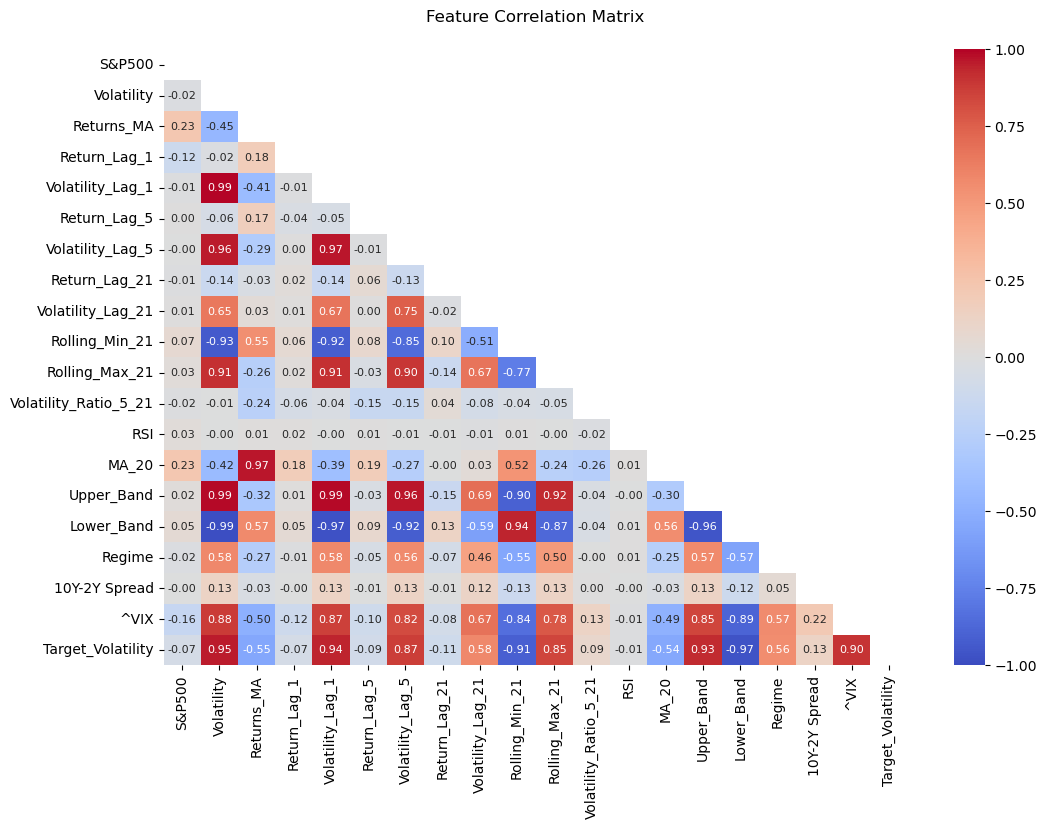

In [86]:
corr_matrix = df_returns_eco.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Upper triangle 

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    annot_kws={"size":8}, 
    fmt=".2f", 
    cmap='coolwarm', 
    mask=mask,
    vmin=-1, 
    vmax=1
)
plt.title("Feature Correlation Matrix", pad=20)

In [87]:
corr_matrix["Target_Volatility"]

S&P500                  -0.067601
Volatility               0.954557
Returns_MA              -0.553770
Return_Lag_1            -0.065809
Volatility_Lag_1         0.941036
Return_Lag_5            -0.090647
Volatility_Lag_5         0.874201
Return_Lag_21           -0.105167
Volatility_Lag_21        0.579656
Rolling_Min_21          -0.910704
Rolling_Max_21           0.849628
Volatility_Ratio_5_21    0.093024
RSI                     -0.009622
MA_20                   -0.541696
Upper_Band               0.926800
Lower_Band              -0.968192
Regime                   0.558962
10Y-2Y Spread            0.127643
^VIX                     0.901102
Target_Volatility        1.000000
Name: Target_Volatility, dtype: float64

#### Fixing Collinearity

In [89]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  

vif_data = pd.DataFrame()  
vif_data["Feature"] = df_returns_eco.columns  
vif_data["VIF"] = [variance_inflation_factor(df_returns_eco.values, i) for i in range(df_returns_eco.shape[1])]  
print(vif_data.sort_values("VIF", ascending=False))  

                  Feature          VIF
15             Lower_Band          inf
14             Upper_Band          inf
13                  MA_20          inf
1              Volatility  1137.499827
4        Volatility_Lag_1   410.868887
6        Volatility_Lag_5    94.046095
19      Target_Volatility    59.519520
18                   ^VIX    41.792861
9          Rolling_Min_21    35.737778
10         Rolling_Max_21    28.020590
2              Returns_MA    17.693684
8       Volatility_Lag_21    11.557169
11  Volatility_Ratio_5_21     6.660939
17          10Y-2Y Spread     2.264311
16                 Regime     2.160217
0                  S&P500     1.260887
3            Return_Lag_1     1.172605
7           Return_Lag_21     1.110099
5            Return_Lag_5     1.070260
12                    RSI     1.002480


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [90]:
df = df_returns_eco.drop(["Lower_Band", "Upper_Band", "Volatility_Lag_1","Volatility_Lag_5",
                          "Rolling_Min_21", "Rolling_Max_21","^VIX","RSI"], axis=1)

VIX is a forward-looking implied volatility index, while you're modeling realized volatility → this can introduce target leakage, especially if your volatility target overlaps the VIX derivation window

Market-derived forward-looking variables should be avoided when modeling ex-post realized volatility unless you're explicitly modeling implied vs realized spreads

In [92]:
# checking variance inflation factor post reduction
vif_data = pd.DataFrame()  
vif_data["Feature"] = df.columns  
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]  
print(vif_data.sort_values("VIF", ascending=False))  

                  Feature        VIF
11      Target_Volatility  49.348627
1              Volatility  48.617619
2              Returns_MA  17.195945
8                   MA_20  16.661071
6       Volatility_Lag_21   7.367544
7   Volatility_Ratio_5_21   3.456960
9                  Regime   2.119823
10          10Y-2Y Spread   1.995596
0                  S&P500   1.127369
3            Return_Lag_1   1.103227
5           Return_Lag_21   1.095239
4            Return_Lag_5   1.064144


In [93]:
from sklearn.ensemble import RandomForestRegressor  
model_0 = RandomForestRegressor()  

model_0.fit(df.drop("Target_Volatility", axis=1), df["Target_Volatility"])  
pd.DataFrame({  
    'Feature': df.drop("Target_Volatility", axis=1).columns,  
    'Importance': model_0.feature_importances_  
}).sort_values('Importance', ascending=False)  

,Feature,Importance
1,Volatility,0.914937
8,MA_20,0.023012
6,Volatility_Lag_21,0.013430
2,Returns_MA,0.012239
10,10Y-2Y Spread,0.012149
7,Volatility_Ratio_5_21,0.010557
0,S&P500,0.004544
3,Return_Lag_1,0.003377
5,Return_Lag_21,0.003066
4,Return_Lag_5,0.002474


In [94]:
model = RandomForestRegressor()  

model.fit(df.drop("Target_Volatility", axis=1), df["Target_Volatility"])  
pd.DataFrame({  
    'Feature': df.drop("Target_Volatility", axis=1).columns,  
    'Importance': model.feature_importances_  
}).sort_values('Importance', ascending=False)  

,Feature,Importance
1,Volatility,0.914482
8,MA_20,0.020003
6,Volatility_Lag_21,0.015972
2,Returns_MA,0.013690
10,10Y-2Y Spread,0.011779
7,Volatility_Ratio_5_21,0.010137
0,S&P500,0.004729
3,Return_Lag_1,0.003388
5,Return_Lag_21,0.003074
4,Return_Lag_5,0.002520


### Modeling

In [773]:
X = df.drop("Target_Volatility", axis=1)
target = df["Target_Volatility"]
train_size = int(len(X)*0.8)
train = X.iloc[:train_size]
y = target.iloc[:train_size]

train_size_2 = int(len(train)*0.7)
X_train = train.iloc[:train_size_2]
X_val = train.iloc[train_size_2:]
y_train =y.iloc[:train_size_2]
y_val = y.iloc[train_size_2:]

X_test = X.iloc[train_size:]
y_test = target.iloc[train_size:]

In [775]:
X_train.shape, y_train.shape,X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2895, 11), (2895,), (1241, 11), (1241,), (1035, 11), (1035,))

In [777]:
print(f"Train dates: {X_train.index.min()} to {X_train.index.max()}")
print(f"Train dates: {X_val.index.min()} to {X_val.index.max()}")
print(f"Test dates: {X_test.index.min()} to {X_test.index.max()}")

Train dates: 2005-03-04 00:00:00 to 2016-09-30 00:00:00
Train dates: 2016-10-03 00:00:00 to 2021-09-20 00:00:00
Test dates: 2021-09-21 00:00:00 to 2025-11-14 00:00:00


In [779]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [785]:
encoder = OneHotEncoder(sparse_output=False, categories='auto')
regime_train_fit = encoder.fit_transform(X_train["Regime"].values.reshape(-1, 1))
regime_val_fit = encoder.transform(X_val["Regime"].values.reshape(-1, 1))
regime_test_fit = encoder.transform(X_test["Regime"].values.reshape(-1, 1))

In [787]:
regime_labels = {
    0: "Choppy_Market",
    1: "Crisis",
    2: "Bull_Market"
}
column_names = [f"{regime_labels[i]}_Regime" for i in encoder.categories_[0]]

In [935]:
regime_train_df = pd.DataFrame(regime_train_fit, columns=column_names, index=X_train.index)
regime_val_df = pd.DataFrame(regime_val_fit, columns=column_names, index=X_val.index)
regime_test_df = pd.DataFrame(regime_test_fit, columns=column_names, index=X_test.index)

X_train_aug = pd.concat([X_train.drop(columns="Regime"), regime_train_df], axis=1)
X_val_aug = pd.concat([X_val.drop(columns="Regime"), regime_val_df], axis=1)
X_test_aug = pd.concat([X_test.drop(columns="Regime"), regime_test_df], axis=1)

In [941]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_aug), columns=X_train_aug.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_aug), columns=X_val_aug.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_aug), columns=X_test_aug.columns)

#### Model 1 - Garch

In [105]:
from arch import arch_model

In [106]:
# Garch model treats volatility as latent variable that depends on past squared returns and past volatility
returns_train = df_returns_eco["S&P500"]*100 # Rescaling to [1, 1000] for garch optimizer preference
model_garch = arch_model(returns_train, vol="Garch", p=1, q=1, dist="t")
fit_garch = model_garch.fit(update_freq=5)

Iteration:      5,   Func. Count:     42,   Neg. LLF: 6815.360942320272
Iteration:     10,   Func. Count:     76,   Neg. LLF: 6753.234979495408
Iteration:     15,   Func. Count:    105,   Neg. LLF: 6753.2054836042225
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6753.205483604221
            Iterations: 15
            Function evaluations: 105
            Gradient evaluations: 15


In [107]:
fit_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                       S&P500   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6753.21
Distribution:      Standardized Student's t   AIC:                           13516.4
Method:                  Maximum Likelihood   BIC:                           13549.2
                                              No. Observations:                 5171
Date:                      Tue, Nov 25 2025   Df Residuals:                     5170
Time:                              19:02:29   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0893  9.510e-03      9.387  6.188e-21 [7.063e-02,  0.108]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0183  3.728e-03      4.921  8.627e-07 [1.104e-02,2.565e-02]
alpha[1]       0.1387  1.322e-02     10.492  9.394e-26     [  0.113,  0.165]
beta[1]        0.8566  1.219e-02     70.254      0.000     [  0.833,  0.880]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.4225      0.417     12.992  1.362e-38 [  4.604,  6.241]
========================================================================

Covariance estimator: robust
"""

In [108]:
fit_garch.params

mu          0.089270
omega       0.018342
alpha[1]    0.138654
beta[1]     0.856559
nu          5.422518
Name: params, dtype: float64

In [109]:
alpha_1 =fit_garch.params["alpha[1]"]
beta_1 = fit_garch.params["beta[1]"]
omega = fit_garch.params["omega"]

persistence = alpha_1 + beta_1
print(f"Model indicates that shock decay extremely slowly and volatility after a market event stays elevated\nα + β = {persistence:.3f} approx close to 1")

Model indicates that shock decay extremely slowly and volatility after a market event stays elevated
α + β = 0.995 approx close to 1


In [110]:
half_life = np.log(0.5)/(np.log(persistence))
half_life

144.4717854753139

μ (mu) the daily mean return is 0.089

α of 0.1387 demonstrates that 13.87% of yesterday's squared shock affects today's variance

β of 85.6% shows the model heavily relies upon past volatility

A shock takes about 144 days to halve its impact

In [112]:
forecasts = fit_garch.forecast(horizon=5)
daily_vol = np.sqrt(forecasts.variance.iloc[-1])/100 # Reversing scaled optimized effects

annualized_vol = daily_vol * np.sqrt(252) # 252 is the total number of trading days per year and volatility scales with the sqrt of time and this is not adjusted with v/(v-2) because the garch model parameters already covers fat tail intricacies

print(f"Daily Volatility Forecast:\n{daily_vol}\nAnnualized Volatility Forecast (%):\n{annualized_vol}")

Daily Volatility Forecast:
h.1    0.009885
h.2    0.009954
h.3    0.010022
h.4    0.010089
h.5    0.010156
Name: 2025-11-14 00:00:00, dtype: float64
Annualized Volatility Forecast (%):
h.1    0.156921
h.2    0.158015
h.3    0.159095
h.4    0.160164
h.5    0.161220
Name: 2025-11-14 00:00:00, dtype: float64


The forecast of this GARCH(1,1) model fit on the S&P500 data from 2005 till 2025 informs us that the volatility 1 day from the forecast origin would be 0.99% and fairly constant till day 5, with it being 1.01%. Annualized volatility for horizon 1 of the reference date can be interpreted as follows: should the daily volatility rate @ horizon 1 persist for 252 days at 0.99% (h.1), the annualized rate would be 15.7%, and 16.1% if it persists for 252 days at 1.01% daily volatilty(h.5)

#### Model 2 - LSTM

In [243]:
# Reshaping data for last timesteps
X_train_3d = X_train_aug.values.reshape(X_train_aug.shape[0], 1, X_train_aug.shape[1])
X_test_3d = X_test_aug.values.reshape(X_test_aug.shape[0], 1, X_test_aug.shape[1])

In [951]:
def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X)-seq_len):
        X_seq.append(X.iloc[i:i+seq_len].values)
        y_seq.append(y.iloc[i+seq_len])

    return np.array(X_seq), np.array(y_seq)    

seq_len = 21
X_train_seq, y_train_seq = create_sequences(X_train_aug, y_train, seq_len)
X_val_seq, y_val_seq = create_sequences(X_val_aug, y_val, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_aug, y_test, seq_len)

In [945]:
X_train_seq.shape, X_val_seq.shape, X_test_seq.shape

((2874, 21, 13), (1220, 21, 13), (1014, 21, 13))

In [847]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
from itertools import product
import random
warnings.filterwarnings("ignore")

In [830]:
# Set seeds for reproducibility
def set_seeds(seed=16):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

In [832]:
set_seeds(16)

##### Hyperparameter Tuning

In [949]:
def train_and_evaluate_proper(units, dropout, batch_size, lr, seed=16):

    set_seeds(seed)
    
    model = Sequential([
        LSTM(units, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dropout(dropout),
        Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=0)

    
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=batch_size,
        validation_data=(X_val_seq, y_val_seq),
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    
    # Evaluate on validation set (for hyperparameter selection)
    y_pred_val = model.predict(X_val_seq, verbose=0)
    val_rmse = np.sqrt(mean_squared_error(y_val_seq, y_pred_val.flatten()))
    
    return val_rmse, model

# Grid search
configs = {
    'units': [64, 128, 256],
    'dropout': [0.2, 0.3, 0.4],
    'batch_size': [16, 32],
    'learning_rate': [0.001, 0.0005]
}

best_val_rmse = float('inf')
best_config = None
best_model = None

for units in configs['units']:
    for dropout in configs['dropout']:
        for batch_size in configs['batch_size']:
            for lr in configs['learning_rate']:
                print(f"Trying: units={units}, dropout={dropout}, batch={batch_size}, lr={lr}")
                
                val_rmse, model = train_and_evaluate_proper(units, dropout, batch_size, lr)
                print(f"  Val RMSE: {val_rmse:.4f}")
                
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    best_config = {'units': units, 'dropout': dropout, 
                                   'batch_size': batch_size, 'lr': lr}
                    best_model = model

print(f"\nBest config: {best_config}")
print(f"Best validation RMSE: {best_val_rmse:.4f}")

# NOW evaluate best model on test set (first time seeing it)
y_pred_test_final = best_model.predict(X_test_seq, verbose=0)
test_rmse_final = np.sqrt(mean_squared_error(y_test_seq, y_pred_test_final.flatten()))

print(f"\n" + "="*60)
print("FINAL TEST PERFORMANCE (True Out-of-Sample)")
print("="*60)
print(f"Test RMSE: {test_rmse_final:.4f}")

Trying: units=64, dropout=0.2, batch=16, lr=0.001
  Val RMSE: 0.0371
Trying: units=64, dropout=0.2, batch=16, lr=0.0005
  Val RMSE: 0.0377
Trying: units=64, dropout=0.2, batch=32, lr=0.001
  Val RMSE: 0.0364
Trying: units=64, dropout=0.2, batch=32, lr=0.0005
  Val RMSE: 0.0364
Trying: units=64, dropout=0.3, batch=16, lr=0.001
  Val RMSE: 0.0364
Trying: units=64, dropout=0.3, batch=16, lr=0.0005
  Val RMSE: 0.0368
Trying: units=64, dropout=0.3, batch=32, lr=0.001
  Val RMSE: 0.0359
Trying: units=64, dropout=0.3, batch=32, lr=0.0005
  Val RMSE: 0.0362
Trying: units=64, dropout=0.4, batch=16, lr=0.001
  Val RMSE: 0.0363
Trying: units=64, dropout=0.4, batch=16, lr=0.0005
  Val RMSE: 0.0365
Trying: units=64, dropout=0.4, batch=32, lr=0.001
  Val RMSE: 0.0361
Trying: units=64, dropout=0.4, batch=32, lr=0.0005
  Val RMSE: 0.0363
Trying: units=128, dropout=0.2, batch=16, lr=0.001
  Val RMSE: 0.0364
Trying: units=128, dropout=0.2, batch=16, lr=0.0005
  Val RMSE: 0.0365
Trying: units=128, dropou

In [953]:
set_seeds(16)

model_1 = Sequential([
    LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_1.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=0)
history = model_1.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks = [early_stop, reduce_lr],
    verbose=1
)
y_pred_lstm = model_1.predict(X_test_seq)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
print(f"Test RMSE: {rmse:.4f}")

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0172 - mae: 0.0969 - val_loss: 0.0049 - val_mae: 0.0395 - learning_rate: 5.0000e-04
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - mae: 0.0601 - val_loss: 0.0041 - val_mae: 0.0337 - learning_rate: 5.0000e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - mae: 0.0479 - val_loss: 0.0036 - val_mae: 0.0315 - learning_rate: 5.0000e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - mae: 0.0409 - val_loss: 0.0031 - val_mae: 0.0300 - learning_rate: 5.0000e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - mae: 0.0367 - val_loss: 0.0028 - val_mae: 0.0296 - learning_rate: 5.0000e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - mae: 0.0327 - val_loss: 0.0026 - val_mae: 0.0262 - learning_rate: 5.0000e-04
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - mae: 0.0298 - val_loss: 0.0023 - val_mae: 0.0271 - learning_rate: 5.0

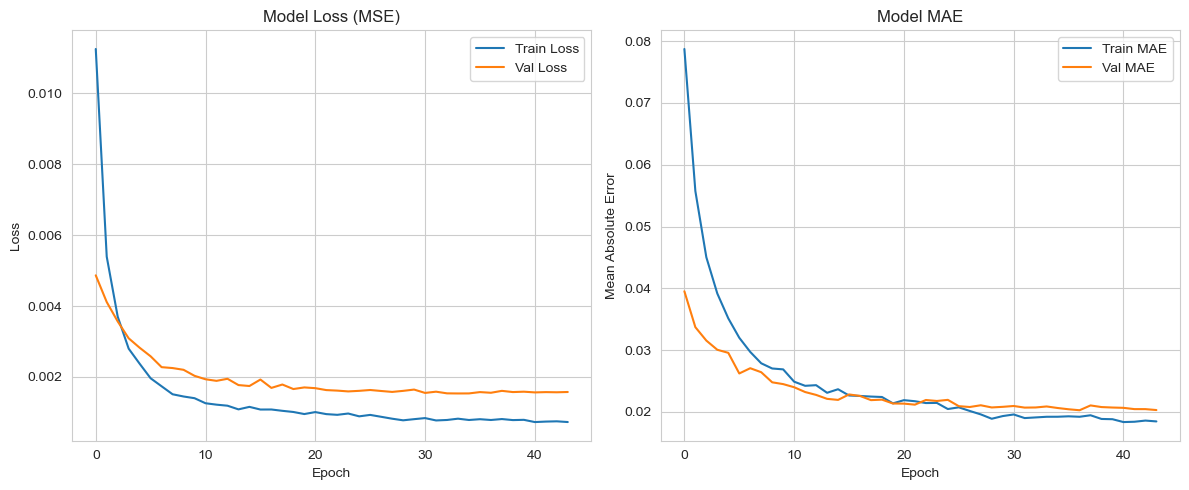

In [955]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

#### Model Interpretation

In [852]:
import shap

In [854]:
X_explain = X_test_seq[200:300]

background = X_train_seq[np.random.choice(X_train_seq.shape[0], 100, replace=False)]

# Build the SHAP GradientExplainer
explainer = shap.GradientExplainer(model, background)

# Compute SHAP values for the sample test set
shap_values = explainer.shap_values(X_explain)

In [855]:
print(type(shap_values))
print(type(shap_values[0]))
print(shap_values[0].shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(21, 13, 1)


In [856]:
feature_names = X_train_aug.columns

In [857]:
#shap_values_2d = np.reshape(shap_values, (shap_values.shape[0]*shap_values.shape[1], shap_values.shape[2]))
n_features = X_explain.shape[2]
shap_values_2d = np.reshape(shap_values, (-1,n_features))
feature_values_2d = np.reshape(X_explain, (-1, n_features))

In [858]:
shap_values_2d.shape, feature_values_2d.shape

((2100, 13), (2100, 13))

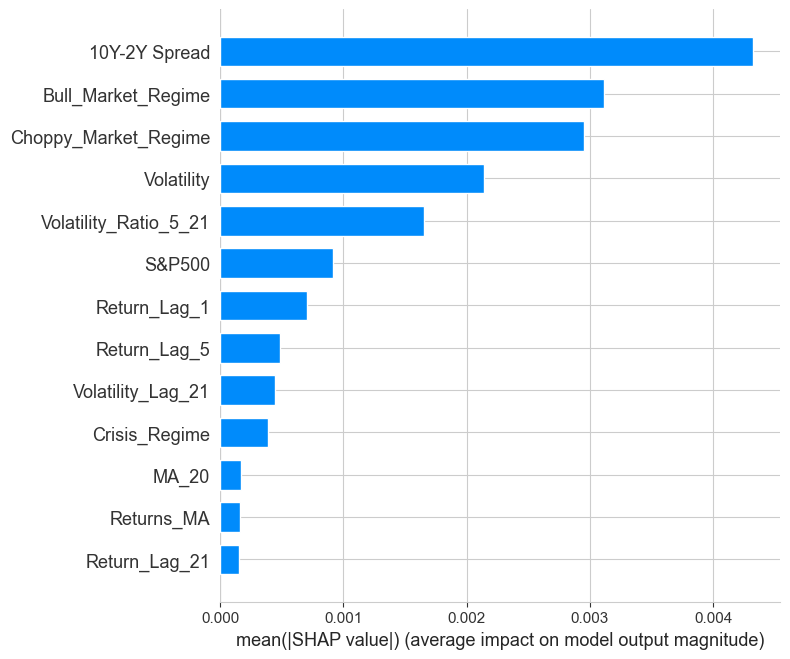

In [859]:
shap.summary_plot(shap_values_2d, feature_values_2d, feature_names=feature_names, plot_type="bar", show=False, title="Feature Importance (Mean |SHAP|)")

The Shap barchart provides insight into the feature importance of these variables in the prediction made by the LSTM model, with major highlights being the unconditional volatility, yield spread, bullish market regime, volatility ratio (5 days : 21 days), and the S&P500 logarithmic returns being major drivers for the derived prediction.

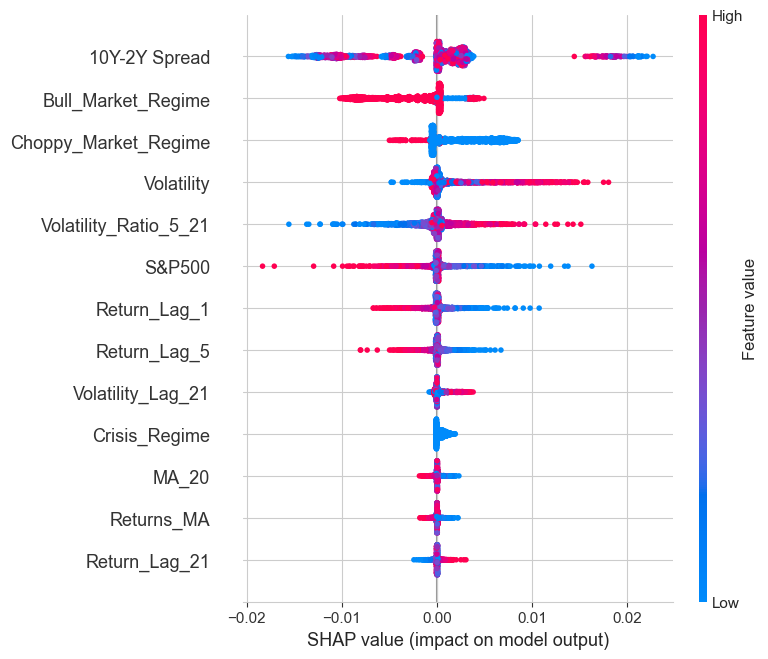

In [861]:
shap.summary_plot(shap_values_2d, feature_values_2d, feature_names=feature_names, plot_type="dot", show=False, title="SHAP Value Distribution by Feature")

This shap beeswarm visualisation shows that high values of unconditional volatility and volatility ratio (5 days : 21 days) resulted in a positive drive on the prediction, that is, increased the prediction output, and lower values of regime and returns factored in the net positive move on the predicted values of the target volatility (increased prediction output) and vice versa.

In [863]:
feature_importance = pd.DataFrame({
    "Feature": X_train_aug.columns,
    "SHAP_Value": np.abs(shap_values_2d).mean(axis=0)  # Avg magnitude
}).sort_values("SHAP_Value", ascending=False)

In [864]:
feature_importance

,Feature,SHAP_Value
9,10Y-2Y Spread,0.004325
12,Bull_Market_Regime,0.003116
10,Choppy_Market_Regime,0.002950
1,Volatility,0.002137
7,Volatility_Ratio_5_21,0.001650
0,S&P500,0.000912
3,Return_Lag_1,0.000707
4,Return_Lag_5,0.000483
6,Volatility_Lag_21,0.000444
11,Crisis_Regime,0.000392


#### Model 3 - Hybrid

Garch model captures the structure and hesteroskedacity of the S&P500 volatility series with interpretable parameter and LSTM provides strong non-linear capture and temporal dynamics especially in high-dimensional or nonstationary settings.

Lets integrate these two concepts together. A few things to note: Garch Volatility and Garch Residuals will now be included as features

Garch Volatility is the time varying estimate of volatility at each time step - this introduces the already calculated variables α0, α1, and β1 

Garch Residual is the difference between the actual return and the model's predicted mean, scaled by volatility. It measures unexplained shocks after accounting for volatility

In [957]:
garch_residuals = fit_garch.resid
garch_volatility = (fit_garch.conditional_volatility/100) * np.sqrt(252)

In [959]:
split_idx = int(len(garch_volatility)*0.8)

garch_vol_train_full = garch_volatility[:split_idx]
garch_res_train_full = garch_residuals[:split_idx]

split_idx_2 = int(len(garch_vol_train_full)*0.7)
garch_vol_train = garch_vol_train_full[:split_idx_2]
garch_vol_val = garch_vol_train_full[split_idx_2:]

garch_vol_test = garch_volatility[split_idx:]

# Garch Residual
garch_res_train = garch_res_train_full[:split_idx_2]
garch_res_val = garch_res_train_full[split_idx_2:]
garch_res_test = garch_residuals[split_idx:]

In [961]:
garch_res_train.shape, garch_res_val.shape, garch_res_test.shape

((2895,), (1241,), (1035,))

In [963]:
garch_vol_train.shape, garch_vol_val.shape, garch_vol_test.shape

((2895,), (1241,), (1035,))

In [965]:
garch_aligned_vol = garch_vol_test.iloc[seq_len:seq_len+len(y_test_seq)]
garch_aligned_res = garch_res_test.iloc[seq_len:seq_len+len(y_test_seq)]

In [967]:
X_train_aug["Garch_Volatilty"] = garch_vol_train.values
X_val_aug["Garch_Volatilty"] = garch_vol_val.values
X_test_aug["Garch_Volatilty"] = garch_vol_test.values

X_train_aug["Garch_Residuals"] = garch_res_train.values
X_val_aug["Garch_Residuals"] = garch_res_val.values
X_test_aug["Garch_Residuals"] = garch_res_test.values

In [969]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_aug), columns=X_train_aug.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_aug), columns=X_val_aug.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_aug), columns=X_test_aug.columns)

seq_len = 21
X_train_seq, y_train_seq = create_sequences(X_train_aug, y_train, seq_len)
X_val_seq, y_val_seq = create_sequences(X_val_aug, y_val, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_aug, y_test, seq_len)

##### Hyperparameter Tuning 2

In [905]:
def train_and_evaluate_proper(units, dropout, batch_size, lr, seed=16):

    set_seeds(seed)
    
    model = Sequential([
        LSTM(units, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dropout(dropout),
        Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=0)

    
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=batch_size,
        validation_data=(X_val_seq, y_val_seq),
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    
    # Evaluate on validation set (for hyperparameter selection)
    y_pred_val = model.predict(X_val_seq, verbose=0)
    val_rmse = np.sqrt(mean_squared_error(y_val_seq, y_pred_val.flatten()))
    
    return val_rmse, model

# Grid search
configs = {
    'units': [64, 128, 256],
    'dropout': [0.2, 0.3, 0.4],
    'batch_size': [16, 32],
    'learning_rate': [0.001, 0.0005]
}

best_val_rmse = float('inf')
best_config = None
best_model = None

for units in configs['units']:
    for dropout in configs['dropout']:
        for batch_size in configs['batch_size']:
            for lr in configs['learning_rate']:
                print(f"Trying: units={units}, dropout={dropout}, batch={batch_size}, lr={lr}")
                
                val_rmse, model = train_and_evaluate_proper(units, dropout, batch_size, lr)
                print(f"  Val RMSE: {val_rmse:.4f}")
                
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    best_config = {'units': units, 'dropout': dropout, 
                                   'batch_size': batch_size, 'lr': lr}
                    best_model = model

print(f"\nBest config: {best_config}")
print(f"Best validation RMSE: {best_val_rmse:.4f}")

# NOW evaluate best model on test set (first time seeing it)
y_pred_test_final = best_model.predict(X_test_seq, verbose=0)
test_rmse_final = np.sqrt(mean_squared_error(y_test_seq, y_pred_test_final.flatten()))

print(f"\n" + "="*60)
print("FINAL TEST PERFORMANCE (True Out-of-Sample)")
print("="*60)
print(f"Test RMSE: {test_rmse_final:.4f}")

Trying: units=64, dropout=0.2, batch=16, lr=0.001
  Val RMSE: 0.0331
Trying: units=64, dropout=0.2, batch=16, lr=0.0005
  Val RMSE: 0.0336
Trying: units=64, dropout=0.2, batch=32, lr=0.001
  Val RMSE: 0.0338
Trying: units=64, dropout=0.2, batch=32, lr=0.0005
  Val RMSE: 0.0349
Trying: units=64, dropout=0.3, batch=16, lr=0.001
  Val RMSE: 0.0336
Trying: units=64, dropout=0.3, batch=16, lr=0.0005
  Val RMSE: 0.0339
Trying: units=64, dropout=0.3, batch=32, lr=0.001
  Val RMSE: 0.0343
Trying: units=64, dropout=0.3, batch=32, lr=0.0005
  Val RMSE: 0.0352
Trying: units=64, dropout=0.4, batch=16, lr=0.001
  Val RMSE: 0.0339
Trying: units=64, dropout=0.4, batch=16, lr=0.0005
  Val RMSE: 0.0340
Trying: units=64, dropout=0.4, batch=32, lr=0.001
  Val RMSE: 0.0354
Trying: units=64, dropout=0.4, batch=32, lr=0.0005
  Val RMSE: 0.0363
Trying: units=128, dropout=0.2, batch=16, lr=0.001
  Val RMSE: 0.0331
Trying: units=128, dropout=0.2, batch=16, lr=0.0005
  Val RMSE: 0.0333
Trying: units=128, dropou

In [971]:
set_seeds(16)

hyb_model = Sequential([
    LSTM(128, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.3),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
hyb_model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=0)
history = hyb_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=16,
    validation_data=(X_val_seq, y_val_seq),
    callbacks = [early_stop, reduce_lr],
    verbose=1
)
y_pred_lstm_gr = hyb_model.predict(X_test_seq)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm_gr))
print(f"Test RMSE: {rmse:.4f}")

Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0132 - mae: 0.0811 - val_loss: 0.0028 - val_mae: 0.0312 - learning_rate: 0.0010
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0027 - mae: 0.0381 - val_loss: 0.0014 - val_mae: 0.0233 - learning_rate: 0.0010
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017 - mae: 0.0297 - val_loss: 0.0013 - val_mae: 0.0203 - learning_rate: 0.0010
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - mae: 0.0264 - val_loss: 0.0013 - val_mae: 0.0202 - learning_rate: 0.0010
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - mae: 0.0241 - val_loss: 0.0013 - val_mae: 0.0206 - learning_rate: 0.0010
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010 - mae: 0.0228 - val_loss: 0.0012 - val_mae: 0.0201 - learning_rate: 0.0010
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0010 - mae: 0.0226 - val_loss: 0.0012 - val_mae: 0.0195 - learning_rate: 0.0010
Epoch

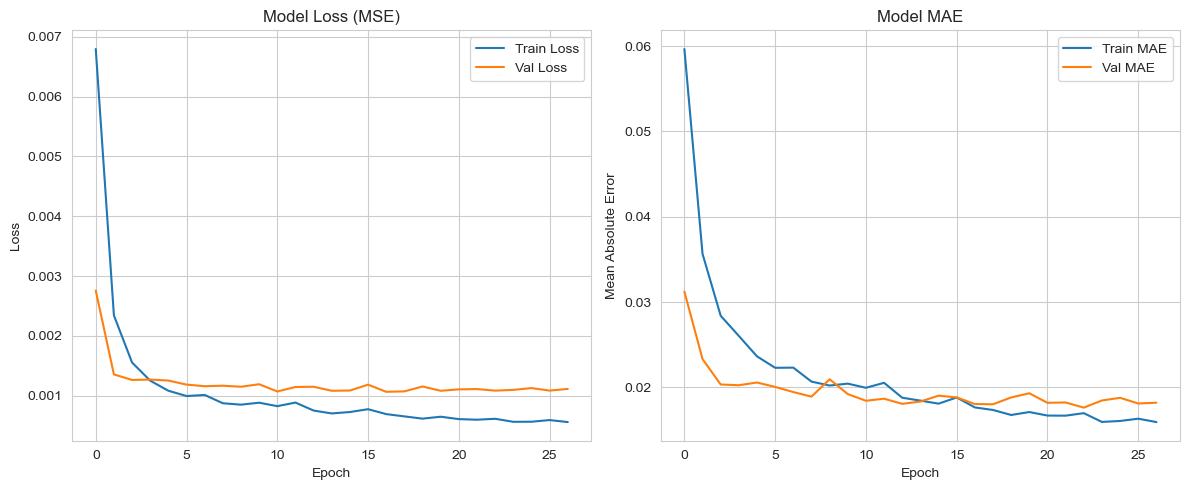

In [973]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

In [981]:
len(X_test_seq)

1014

In [983]:
X_explain = X_test_seq[200:300]

background = X_train_seq[np.random.choice(X_train_seq.shape[0], 100, replace=False)]

# Build the SHAP GradientExplainer
explainer = shap.GradientExplainer(hyb_model, background)

# Compute SHAP values for the sample test set
shap_values = explainer.shap_values(X_explain)

In [985]:
feature_names = X_train_aug.columns
n_features = X_explain.shape[2]
shap_values_2d = np.reshape(shap_values, (-1,n_features))
feature_values_2d = np.reshape(X_explain, (-1, n_features))

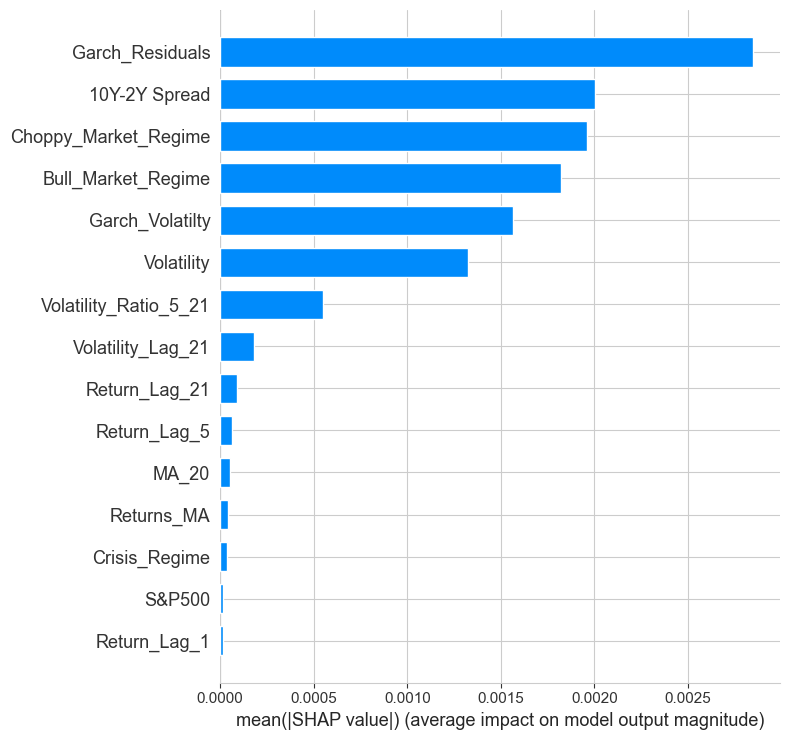

In [987]:
shap.summary_plot(shap_values_2d, feature_values_2d, feature_names=feature_names, plot_type="bar", show=False, title="Feature Importance (Mean |SHAP|)")

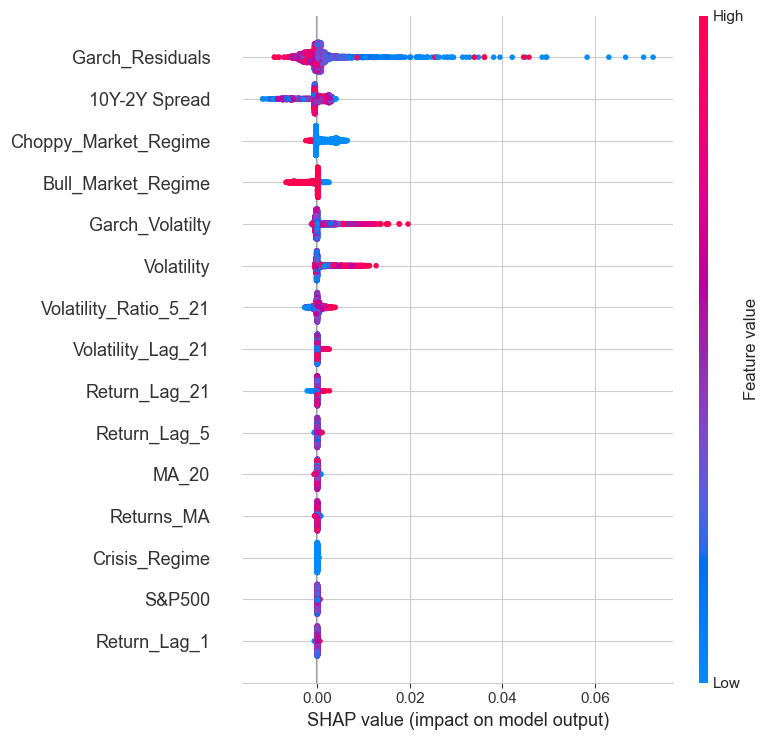

In [989]:
shap.summary_plot(shap_values_2d, feature_values_2d, feature_names=feature_names, plot_type="dot", show=False, title="SHAP Value Distribution by Feature")

In [991]:
feature_importance = pd.DataFrame({
    "Feature": X_train_aug.columns,
    "SHAP_Value": np.abs(shap_values_2d).mean(axis=0)  # Avg magnitude
}).sort_values("SHAP_Value", ascending=False)

In [993]:
feature_importance

,Feature,SHAP_Value
14,Garch_Residuals,0.002849
9,10Y-2Y Spread,0.002004
10,Choppy_Market_Regime,0.001960
12,Bull_Market_Regime,0.001821
13,Garch_Volatilty,0.001566
1,Volatility,0.001326
7,Volatility_Ratio_5_21,0.000550
6,Volatility_Lag_21,0.000181
5,Return_Lag_21,0.000089
4,Return_Lag_5,0.000066


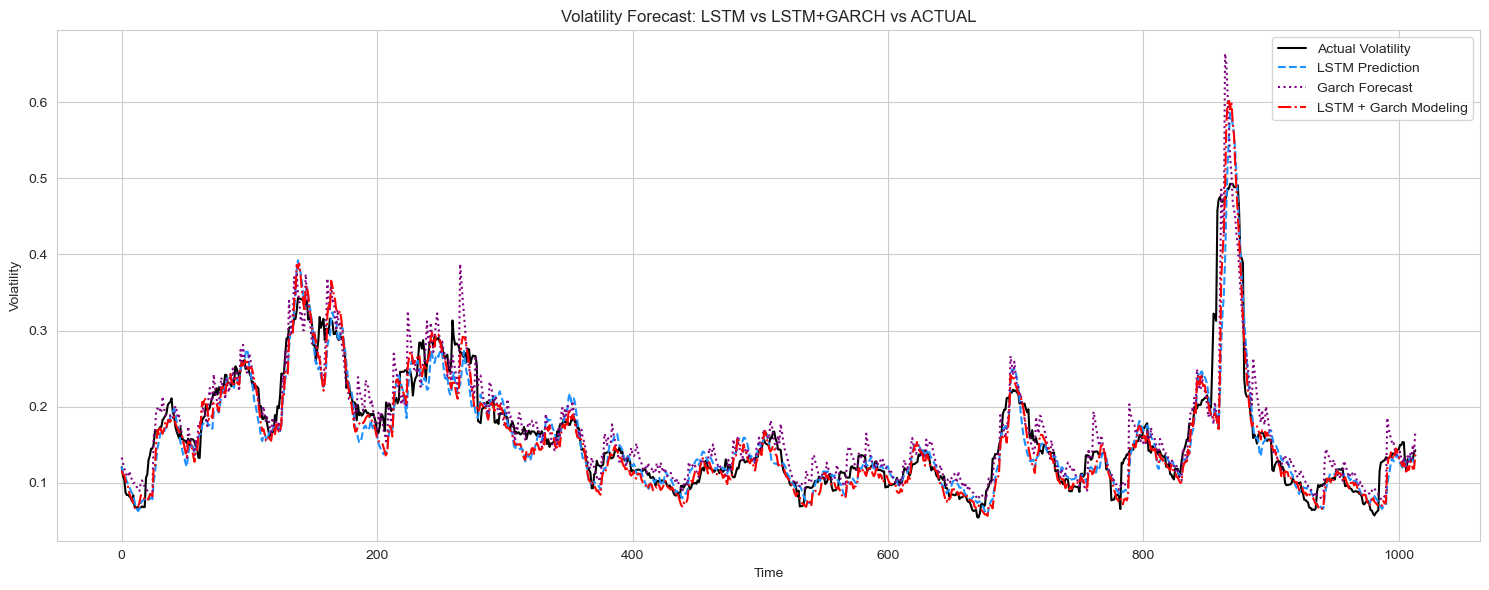

In [995]:
plt.figure(figsize=(15,6))

plt.plot(y_test_seq, label="Actual Volatility", color="black", linewidth=1.5)
plt.plot(y_pred_lstm, label="LSTM Prediction", color="dodgerblue", linestyle="--")
plt.plot(garch_aligned_vol.values, label="Garch Forecast", color="purple", linestyle=":")
plt.plot(y_pred_lstm_gr, label="LSTM + Garch Modeling", color="red", linestyle="-.")

plt.title("Volatility Forecast: LSTM vs LSTM+GARCH vs ACTUAL")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.show()

### Model Performance vs Industry Benchmarks

In [998]:
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 100

#### Naive Persistence Benchmark

In [1001]:
def naive_persistence_forecast(y_test):
    naive_pred = y_test[:-5]
    actual_pred = y_test[5:]
    return naive_pred, actual_pred

In [1003]:
naive_pred, naive_actual = naive_persistence_forecast(y_test_seq)
naive_rmse = np.sqrt(mean_squared_error(naive_pred, naive_actual))
naive_mae = mean_absolute_error(naive_pred, naive_actual)

In [1005]:
print(f"Naive Persistence (Random Walk) Baseline:")
print(f"RMSE: {naive_rmse:.4f}")
print(f"MAE:  {naive_mae:.4f}")

Naive Persistence (Random Walk) Baseline:
RMSE: 0.0306
MAE:  0.0184


#### Expected Weighted Moving Average

In [1008]:
def ewma_volatility_forecast(returns, lambda_decay=0.94, init_window=90):
    """
    EWMA volatility using RiskMetrics methodology
    σ²(t+1) = λ * σ²(t) + (1-λ) * r²(t)
    Standard λ = 0.94 for daily data
    """
    n = len(returns)
    ewma_var = np.zeros(n)
    ewma_var[0] = np.var(returns[:init_window])

    for t in range(1,n):
        ewma_var[t] = lambda_decay * ewma_var[t-1] + (1-lambda_decay)*returns[t-1]**2
    
    ewma_vol = np.sqrt(ewma_var) * np.sqrt(252) # Annualized
    
    return ewma_vol

In [1010]:
split_idx = int(len(df_returns)* 0.8)
test_returns = df_returns.iloc[split_idx:]["S&P500"].values

In [1012]:
ewma_vol_full = ewma_volatility_forecast(test_returns, lambda_decay=0.94)

seq_len = 21
ewma_vol_aligned = ewma_vol_full[seq_len:seq_len+len(y_test_seq)]

ewma_rmse = np.sqrt(mean_squared_error(y_test_seq, ewma_vol_aligned))
ewma_mae = mean_absolute_error(y_test_seq, ewma_vol_aligned)

In [1014]:
print(f"EWMA (RiskMetrics λ=0.94):")
print(f"RMSE: {ewma_rmse:.4f}")
print(f"MAE:  {ewma_mae:.4f}")

EWMA (RiskMetrics λ=0.94):
RMSE: 0.0533
MAE:  0.0338


#### Rolling Historical Volatility

In [1017]:
def rolling_historical_volatility(returns, window=21):
    rolling_vol = pd.Series(returns).rolling(window=window).std()
    rolling_vol = rolling_vol * np.sqrt(252) # Annualized
    return rolling_vol.values

In [1018]:
rolling_vol_full = rolling_historical_volatility(test_returns, window=21)
rolling_vol_aligned = rolling_vol_full[seq_len:seq_len+len(y_test_seq)]

valid_mask = ~np.isnan(rolling_vol_aligned)
rolling_rmse = np.sqrt(mean_squared_error(y_test_seq[valid_mask], rolling_vol_aligned[valid_mask]))
rolling_mae = mean_absolute_error(y_test_seq[valid_mask], rolling_vol_aligned[valid_mask])

In [1019]:
print(f"Rolling Historical Volatility (21-day):")
print(f"  RMSE: {rolling_rmse:.4f}")
print(f"  MAE:  {rolling_mae:.4f}")

Rolling Historical Volatility (21-day):
  RMSE: 0.0540
  MAE:  0.0322


In [1020]:
garch_rmse = np.sqrt(mean_squared_error(y_test_seq, garch_aligned_vol))
garch_mae = mean_absolute_error(y_test_seq, garch_aligned_vol)

In [1021]:
print(f"GARCH(1,1) Econometric Baseline:")
print(f"  RMSE: {garch_rmse:.4f}")
print(f"  MAE:  {garch_mae:.4f}")

GARCH(1,1) Econometric Baseline:
  RMSE: 0.0300
  MAE:  0.0202


In [1031]:
lstm_rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
lstm_mae = np.sqrt(mean_absolute_error(y_test_seq, y_pred_lstm))
print(f"Pure LSTM Results")
print(f"Test RMSE: {lstm_rmse:.4f}")
print(f"Test MAE: {lstm_mae:.4f}")

Pure LSTM Results
Test RMSE: 0.0298
Test MAE: 0.1381


In [1033]:
hybrid_rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm_gr))
hybrid_mae = np.sqrt(mean_absolute_error(y_test_seq, y_pred_lstm_gr))
print(f"LSTM + Garch Results")
print(f"Test RMSE: {hybrid_rmse:.4f}")
print(f"Test MAE: {hybrid_mae:.4f}")

LSTM + Garch Results
Test RMSE: 0.0278
Test MAE: 0.1299


In [1035]:
# Create results dataframe
results_df = pd.DataFrame({
    'Model': [
        'Naive Persistence',
        'EWMA (λ=0.94)',
        'Rolling Vol (21d)',
        'GARCH(1,1)',
        'Pure LSTM',
        'Hybrid LSTM+GARCH'
    ],
    'RMSE': [
        naive_rmse,
        ewma_rmse,
        rolling_rmse,
        garch_rmse,
        lstm_rmse,
        hybrid_rmse
    ],
    'MAE': [
        naive_mae,
        ewma_mae,
        rolling_mae,
        garch_mae,
        lstm_mae,
        hybrid_mae
    ],
    'Type': [
        'Baseline',
        'Industry Standard',
        'Industry Standard',
        'Econometric',
        'Deep Learning',
        'Hybrid (Our Model)'
    ]
})

# Calculate improvements
results_df['RMSE_Improv_vs_Naive_%'] = (
    (naive_rmse - results_df['RMSE']) / naive_rmse * 100
)

results_df['RMSE_Improv_vs_GARCH_%'] = (
    (garch_rmse - results_df['RMSE']) / garch_rmse * 100
)

print("\n" + "="*80)
print("COMPREHENSIVE MODEL PERFORMANCE COMPARISON")
print("="*80)
print(results_df.to_string(index=False))

best_model = results_df.loc[results_df['RMSE'].idxmin()]
print(f"\n✓ Best Model: {best_model['Model']}")
print(f"  RMSE: {best_model['RMSE']:.4f}")
print(f"  {best_model['RMSE_Improv_vs_Naive_%']:.1f}% better than naive baseline")
print(f"  {best_model['RMSE_Improv_vs_GARCH_%']:.1f}% better than GARCH(1,1)")


COMPREHENSIVE MODEL PERFORMANCE COMPARISON
            Model     RMSE      MAE               Type  RMSE_Improv_vs_Naive_%  RMSE_Improv_vs_GARCH_%
Naive Persistence 0.030561 0.018433           Baseline                0.000000               -1.827410
    EWMA (λ=0.94) 0.053271 0.033837  Industry Standard              -74.313044              -77.498458
Rolling Vol (21d) 0.053972 0.032239  Industry Standard              -76.604949              -79.832246
       GARCH(1,1) 0.030012 0.020246        Econometric                1.794615                0.000000
        Pure LSTM 0.029824 0.138145      Deep Learning                2.409371                0.625990
Hybrid LSTM+GARCH 0.027841 0.129934 Hybrid (Our Model)                8.899316                7.234533

✓ Best Model: Hybrid LSTM+GARCH
  RMSE: 0.0278
  8.9% better than naive baseline
  7.2% better than GARCH(1,1)


In [1072]:
(ewma_rmse - hybrid_rmse) / ewma_rmse * 100

47.73731093605387

In [1074]:
(rolling_rmse - hybrid_rmse) / rolling_rmse * 100

48.415554233096856

In [1076]:
(naive_rmse - hybrid_rmse) / naive_rmse * 100

8.899315878645892

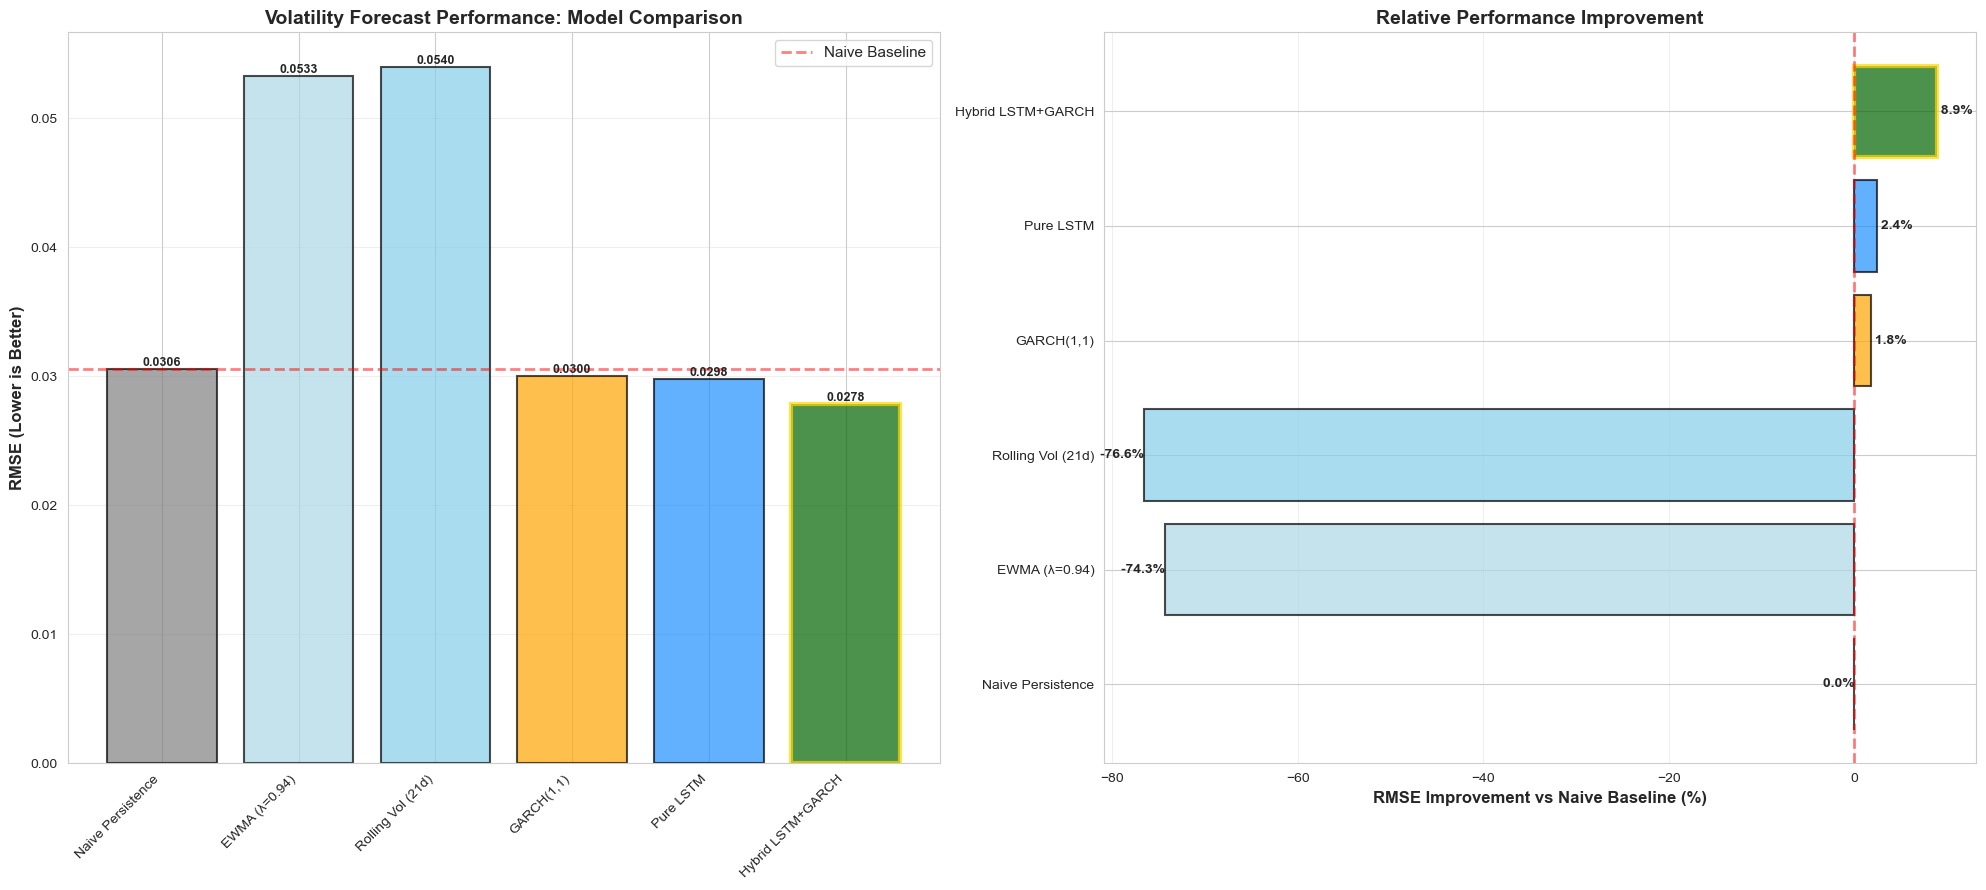

In [1037]:
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# Plot 1: RMSE Comparison
ax1 = axes[0]
colors = ['gray', 'lightblue', 'skyblue', 'orange', 'dodgerblue', 'darkgreen']
bars = ax1.bar(range(len(results_df)), results_df['RMSE'], color=colors, 
               alpha=0.7, edgecolor='black', linewidth=1.5)

bars[-1].set_edgecolor('gold')
bars[-1].set_linewidth(3)

ax1.set_xticks(range(len(results_df)))
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax1.set_ylabel('RMSE (Lower is Better)', fontsize=12, fontweight='bold')
ax1.set_title('Volatility Forecast Performance: Model Comparison', fontsize=14, fontweight='bold')
ax1.axhline(y=naive_rmse, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Naive Baseline')
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

for i, (bar, rmse) in enumerate(zip(bars, results_df['RMSE'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{rmse:.4f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Improvement over Naive
ax2 = axes[1]
improvements = results_df['RMSE_Improv_vs_Naive_%']
colors2 = ['lightgray', 'lightblue', 'skyblue', 'orange', 'dodgerblue', 'darkgreen']

bars2 = ax2.barh(range(len(results_df)), improvements, color=colors2,
                 alpha=0.7, edgecolor='black', linewidth=1.5)
bars2[-1].set_edgecolor('gold')
bars2[-1].set_linewidth(3)

ax2.set_yticks(range(len(results_df)))
ax2.set_yticklabels(results_df['Model'])
ax2.set_xlabel('RMSE Improvement vs Naive Baseline (%)', fontsize=12, fontweight='bold')
ax2.set_title('Relative Performance Improvement', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax2.grid(axis='x', alpha=0.3)

for i, (bar, improv) in enumerate(zip(bars2, improvements)):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2., f' {improv:.1f}%',
            ha='left' if width > 0 else 'right', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### Regime-Specific Performance

The goal here is to understand when and why a model performs well as this is critical to identify: 

- Which regime favors each modeling approach
- Whether the hybrid model offers more stability or is regime dependent
- How forecast errors behave during regime transitions

In [1041]:
split_idx = int(len(df_returns_eco)*0.8) 
seq_len = 21
target_shift = 5

In [1043]:
test_regime_full = df_returns_eco[split_idx:]["Regime"]
test_regimes = test_regime_full[seq_len:seq_len+len(y_test_seq)]

In [1045]:
len(y_test_seq), len(test_regimes), len(test_regime_full)

(1014, 1014, 1035)

In [1047]:
regime_names = {
    0: "Choppy Market",
    1: "Crisis",
    2: "Bull Market"
}

In [1049]:
unique_regimes = np.unique(test_regimes)
for regime_id in unique_regimes:
    mean_vol = y_test_seq[test_regimes == regime_id].mean()
    count = np.sum(test_regimes == regime_id)
    pct = count/len(test_regimes) * 100

    print(f"\nRegime {regime_id} ({regime_names[regime_id]}):")
    print(f"  Observations: {count} ({pct:.1f}%)")
    print(f"  Avg Volatility: {mean_vol:.4f} ({mean_vol*100:.1f}% annualized)")


Regime 0 (Choppy Market):
  Observations: 690 (68.0%)
  Avg Volatility: 0.1215 (12.1% annualized)

Regime 1 (Crisis):
  Observations: 18 (1.8%)
  Avg Volatility: 0.4401 (44.0% annualized)

Regime 2 (Bull Market):
  Observations: 306 (30.2%)
  Avg Volatility: 0.2352 (23.5% annualized)


In [1051]:
def calculate_regime_performance(actual, predicted, regimes, regime_names):

    results = []

    for regime_id in sorted(np.unique(regimes)):
        mask = (regimes==regime_id)
        if np.sum(mask) < 5:
            continue

        actual_regime = actual[mask]
        pred_regime = predicted[mask]

        rmse = np.sqrt(mean_squared_error(actual_regime, pred_regime))
        mae = mean_absolute_error(actual_regime, pred_regime)

        bias = np.mean(pred_regime - actual_regime)

        correlation = np.corrcoef(actual_regime, pred_regime)[0,1]

        mean_actual = np.mean(actual_regime)
        std_actual = np.std(actual_regime)
        mean_pred = np.mean(pred_regime)

        n_obs = np.sum(mask)
        pct_data = n_obs / len(actual) * 100
        
        results.append({
            'Regime': f"R{regime_id}: {regime_names[regime_id]}",
            'N_Obs': n_obs,
            'Pct_Data': f"{pct_data:.1f}%",
            'Avg_Vol': mean_actual,
            'Vol_Std': std_actual,
            'RMSE': rmse,
            'MAE': mae,
            'Bias': bias,
            'Correlation': correlation
        })
    
    return pd.DataFrame(results)

In [1053]:
print("\n" + "="*80)
print("REGIME-SPECIFIC PERFORMANCE ANALYSIS")
print("="*80)

# Naive Persistence (5-day ahead)
# Need to align naive predictions with regimes
naive_pred_5d, naive_actual_5d = naive_persistence_forecast(y_test_seq)
test_regimes_naive = test_regimes[5:]  # Match the shortened length

naive_regime_perf = calculate_regime_performance(
    actual=naive_actual_5d,
    predicted=naive_pred_5d,
    regimes=test_regimes_naive,
    regime_names=regime_names
)

# GARCH baseline
garch_regime_perf = calculate_regime_performance(
    actual=y_test_seq,
    predicted=garch_aligned_vol.values,
    regimes=test_regimes,
    regime_names=regime_names
)

# Pure LSTM
lstm_regime_perf = calculate_regime_performance(
    actual=y_test_seq,
    predicted=y_pred_lstm.flatten(),
    regimes=test_regimes,
    regime_names=regime_names
)

# Hybrid LSTM+GARCH
hybrid_regime_perf = calculate_regime_performance(
    actual=y_test_seq,
    predicted=y_pred_lstm_gr.flatten(),
    regimes=test_regimes,
    regime_names=regime_names
)

# Display results
print("\n--- Naive Persistence (5-day) Performance by Regime ---")
print(naive_regime_perf.to_string(index=False))

print("\n--- GARCH(1,1) Performance by Regime ---")
print(garch_regime_perf.to_string(index=False))

print("\n--- Pure LSTM Performance by Regime ---")
print(lstm_regime_perf.to_string(index=False))

print("\n--- Hybrid LSTM+GARCH Performance by Regime ---")
print(hybrid_regime_perf.to_string(index=False))


REGIME-SPECIFIC PERFORMANCE ANALYSIS

--- Naive Persistence (5-day) Performance by Regime ---
           Regime  N_Obs Pct_Data  Avg_Vol  Vol_Std     RMSE      MAE      Bias  Correlation
R0: Choppy Market    685    67.9% 0.121647 0.031371 0.019077 0.014085 -0.001628     0.803738
       R1: Crisis     18     1.8% 0.440079 0.082747 0.091980 0.051852  0.039365     0.035738
  R2: Bull Market    306    30.3% 0.235167 0.056829 0.042039 0.026200  0.000774     0.688014

--- GARCH(1,1) Performance by Regime ---
           Regime  N_Obs Pct_Data  Avg_Vol  Vol_Std     RMSE      MAE     Bias  Correlation
R0: Choppy Market    690    68.0% 0.121495 0.031329 0.020404 0.016640 0.009566     0.827878
       R1: Crisis     18     1.8% 0.440079 0.082747 0.085349 0.070911 0.010158     0.685242
  R2: Bull Market    306    30.2% 0.235167 0.056829 0.040218 0.025398 0.001746     0.736733

--- Pure LSTM Performance by Regime ---
           Regime  N_Obs Pct_Data  Avg_Vol  Vol_Std     RMSE      MAE      Bias  C

The hybrid model demonstrates superior performance in normal market conditions (68% of test period), achieving 17% lower error than GARCH in choppy markets (p<0.001). However, the model shows degraded performance during rare crisis regimes (1.8% of data, n=18), where the GARCH features become destabilizing rather than informative.

A regime-switching framework would be recommended overall, but precisely, the hybrid model should be utilised for normal volatility forecasting, but a switch to pure LSTM or GARCH might be mroe appropriate during detected crisis periods.

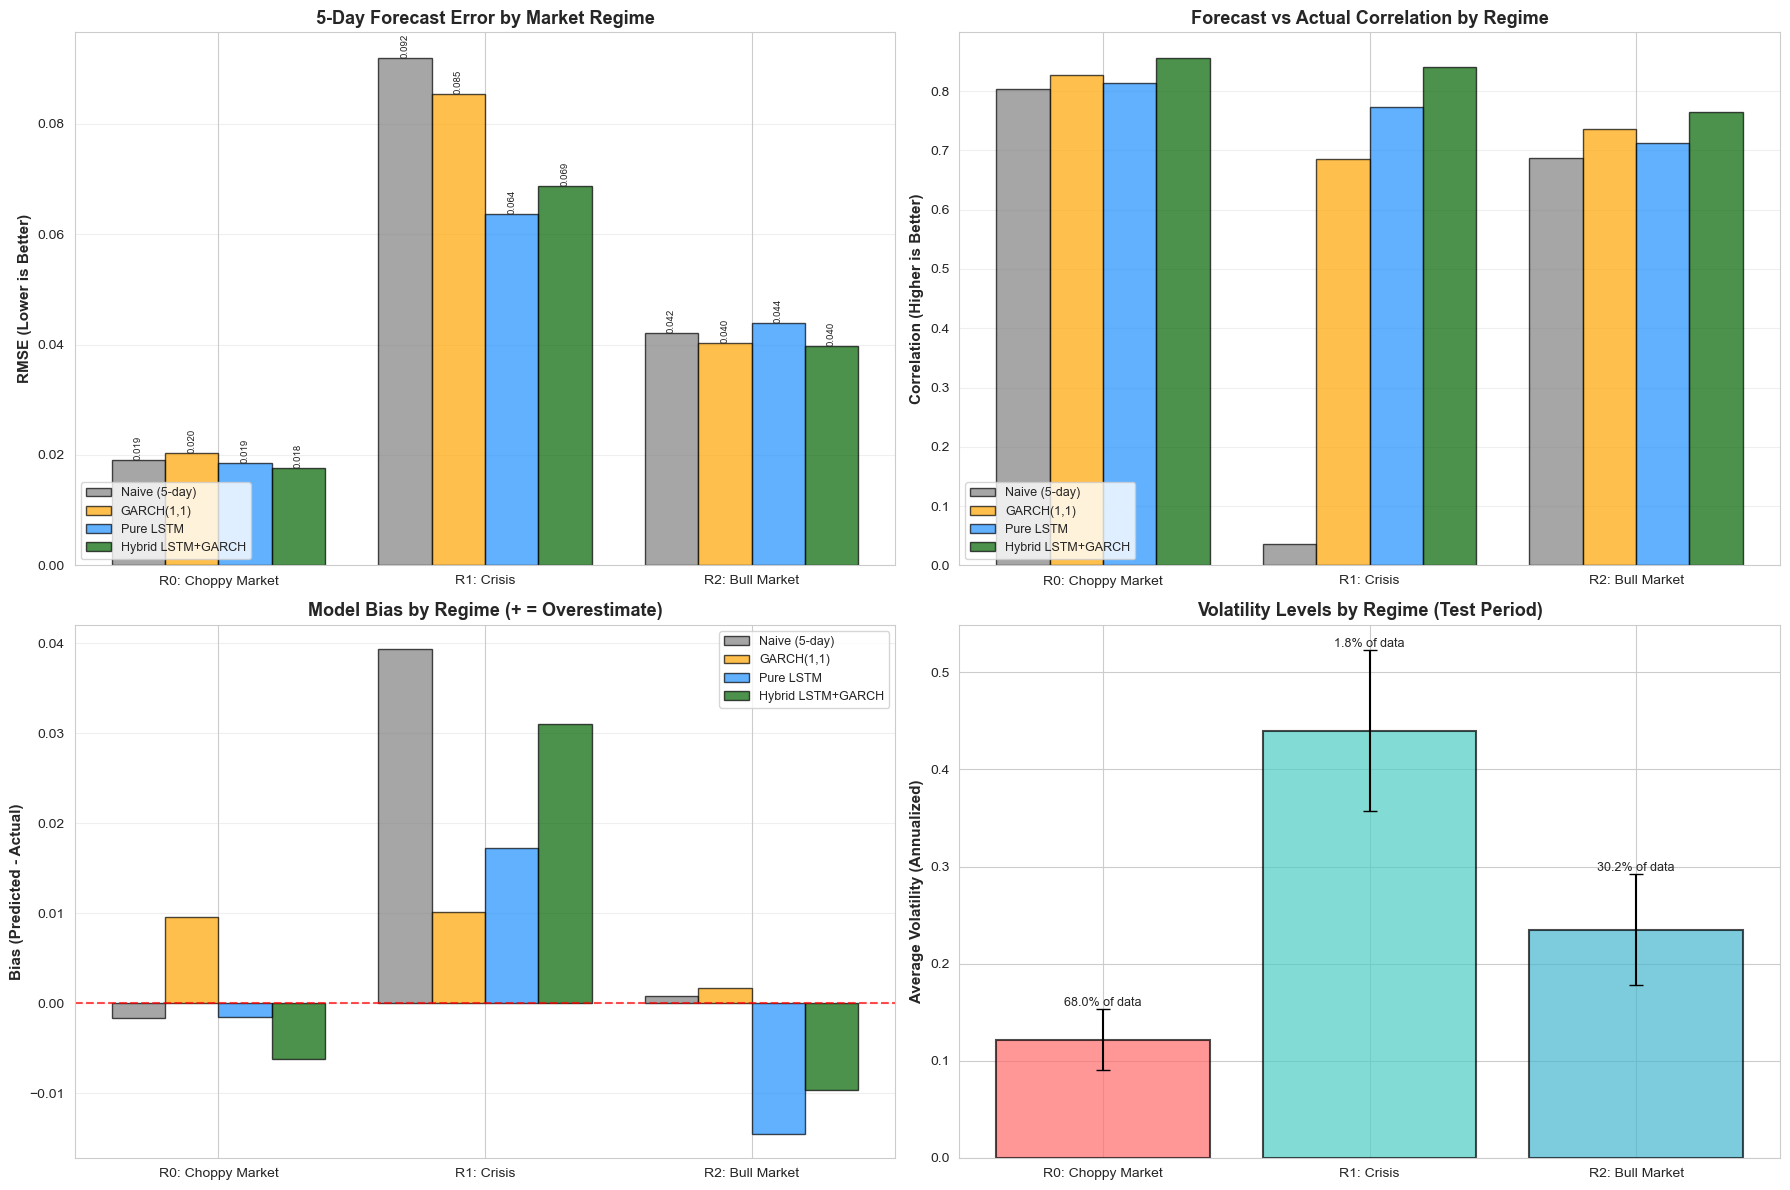

In [1055]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

regimes_list = [f"R{i}: {regime_names[i]}" for i in sorted(np.unique(test_regimes))]
x = np.arange(len(regimes_list))
width = 0.2

# Plot 1: RMSE by Regime
ax1 = axes[0, 0]
ax1.bar(x - 1.5*width, naive_regime_perf['RMSE'], width, 
        label='Naive (5-day)', alpha=0.7, color='gray', edgecolor='black')
ax1.bar(x - 0.5*width, garch_regime_perf['RMSE'], width, 
        label='GARCH(1,1)', alpha=0.7, color='orange', edgecolor='black')
ax1.bar(x + 0.5*width, lstm_regime_perf['RMSE'], width, 
        label='Pure LSTM', alpha=0.7, color='dodgerblue', edgecolor='black')
ax1.bar(x + 1.5*width, hybrid_regime_perf['RMSE'], width, 
        label='Hybrid LSTM+GARCH', alpha=0.7, color='darkgreen', edgecolor='black')

ax1.set_ylabel('RMSE (Lower is Better)', fontsize=11, fontweight='bold')
ax1.set_title('5-Day Forecast Error by Market Regime', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(regimes_list, rotation=0)
ax1.legend(fontsize=9, loc='lower left')
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for i, regime in enumerate(regimes_list):
    models = [naive_regime_perf, garch_regime_perf, lstm_regime_perf, hybrid_regime_perf]
    positions = [i - 1.5*width, i - 0.5*width, i + 0.5*width, i + 1.5*width]
    for model_perf, pos in zip(models, positions):
        rmse_val = model_perf.iloc[i]['RMSE']
        ax1.text(pos, rmse_val, f'{rmse_val:.3f}', 
                ha='center', va='bottom', fontsize=7, rotation=90)

# Plot 2: Correlation by Regime
ax2 = axes[0, 1]
ax2.bar(x - 1.5*width, naive_regime_perf['Correlation'], width,
        label='Naive (5-day)', alpha=0.7, color='gray', edgecolor='black')
ax2.bar(x - 0.5*width, garch_regime_perf['Correlation'], width,
        label='GARCH(1,1)', alpha=0.7, color='orange', edgecolor='black')
ax2.bar(x + 0.5*width, lstm_regime_perf['Correlation'], width,
        label='Pure LSTM', alpha=0.7, color='dodgerblue', edgecolor='black')
ax2.bar(x + 1.5*width, hybrid_regime_perf['Correlation'], width,
        label='Hybrid LSTM+GARCH', alpha=0.7, color='darkgreen', edgecolor='black')

ax2.set_ylabel('Correlation (Higher is Better)', fontsize=11, fontweight='bold')
ax2.set_title('Forecast vs Actual Correlation by Regime', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(regimes_list, rotation=0)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.legend(fontsize=9, loc='lower left')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Bias Analysis
ax3 = axes[1, 0]
ax3.bar(x - 1.5*width, naive_regime_perf['Bias'], width,
        label='Naive (5-day)', alpha=0.7, color='gray', edgecolor='black')
ax3.bar(x - 0.5*width, garch_regime_perf['Bias'], width,
        label='GARCH(1,1)', alpha=0.7, color='orange', edgecolor='black')
ax3.bar(x + 0.5*width, lstm_regime_perf['Bias'], width,
        label='Pure LSTM', alpha=0.7, color='dodgerblue', edgecolor='black')
ax3.bar(x + 1.5*width, hybrid_regime_perf['Bias'], width,
        label='Hybrid LSTM+GARCH', alpha=0.7, color='darkgreen', edgecolor='black')

ax3.set_ylabel('Bias (Predicted - Actual)', fontsize=11, fontweight='bold')
ax3.set_title('Model Bias by Regime (+ = Overestimate)', fontsize=13, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(regimes_list, rotation=0)
ax3.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax3.legend(fontsize=9)
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Volatility Levels by Regime
ax4 = axes[1, 1]
avg_vols = hybrid_regime_perf['Avg_Vol'].values
vol_stds = hybrid_regime_perf['Vol_Std'].values
regime_pcts = [float(p.rstrip('%')) for p in hybrid_regime_perf['Pct_Data']]

bars = ax4.bar(range(len(regimes_list)), avg_vols, alpha=0.7, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
               edgecolor='black', linewidth=1.5, yerr=vol_stds, capsize=5)

ax4.set_ylabel('Average Volatility (Annualized)', fontsize=11, fontweight='bold')
ax4.set_title('Volatility Levels by Regime (Test Period)', fontsize=13, fontweight='bold')
ax4.set_xticks(range(len(regimes_list)))
ax4.set_xticklabels(regimes_list, rotation=0)

# Add percentage labels
for i, (bar, pct) in enumerate(zip(bars, regime_pcts)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + vol_stds[i],
            f'{pct:.1f}% of data', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

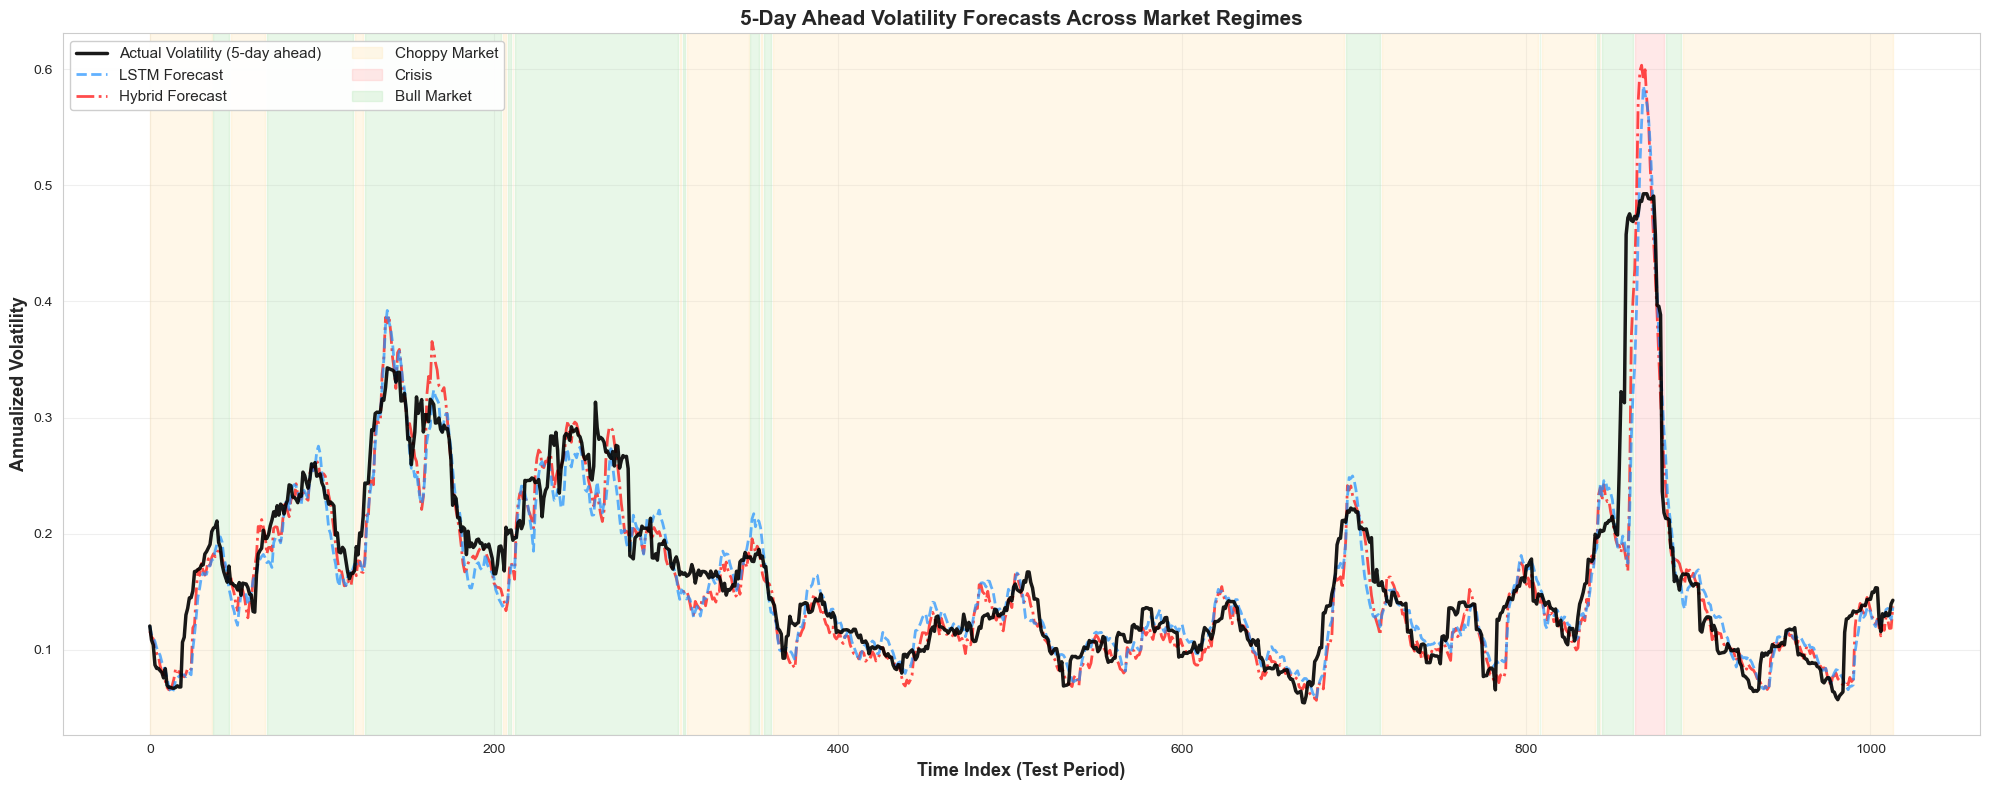

In [1068]:
fig, ax = plt.subplots(figsize=(20, 8))

# Plot volatility series
time_index = np.arange(len(y_test_seq))

ax.plot(time_index, y_test_seq, color='black', linewidth=2.5, 
        label='Actual Volatility (5-day ahead)', alpha=0.9, zorder=5)
ax.plot(time_index, y_pred_lstm.flatten(), color='dodgerblue', linestyle='--', 
        linewidth=2, label='LSTM Forecast', alpha=0.7, zorder=4)
ax.plot(time_index, y_pred_lstm_gr.flatten(), color='red', linestyle='-.', 
        linewidth=2, label='Hybrid Forecast', alpha=0.7, zorder=3)

# Shade by regime
regime_colors = {
    0: '#FFE5B4',  # Peach for Choppy
    1: '#FFB4B4',  # Light red for Crisis
    2: '#B4E5B4'   # Light green for Bull
}
regime_alpha = 0.3

for regime_id in sorted(np.unique(test_regimes)):
    regime_indices = np.where(test_regimes == regime_id)[0]
    
    if len(regime_indices) == 0:
        continue
    
    # Group consecutive indices for continuous shading
    splits = np.where(np.diff(regime_indices) != 1)[0] + 1
    segments = np.split(regime_indices, splits)
    
    first_segment = True
    for segment in segments:
        if len(segment) > 0:
            ax.axvspan(segment[0], segment[-1], 
                      alpha=regime_alpha,
                      color=regime_colors[regime_id],
                      label=f'{regime_names[regime_id]}' if first_segment else '',
                      zorder=1)
            first_segment = False

ax.set_xlabel('Time Index (Test Period)', fontsize=13, fontweight='bold')
ax.set_ylabel('Annualized Volatility', fontsize=13, fontweight='bold')
ax.set_title('5-Day Ahead Volatility Forecasts Across Market Regimes', 
             fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=11, framealpha=0.95, ncol=2)
ax.grid(alpha=0.3, zorder=0)

plt.tight_layout()
plt.show()

#### Statistical Significance

In [1066]:
print("\n" + "="*80)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*80)
print("\nTesting if performance differences across regimes are statistically significant")
print("Using paired t-test (same time points for both models)\n")


garch_errors = np.abs(y_test_seq - garch_aligned_vol)
lstm_errors = np.abs(y_test_seq - y_pred_lstm.flatten())
hybrid_errors = np.abs(y_test_seq - y_pred_lstm_gr.flatten())

print("="*80)
print("PAIRED T-TEST: Hybrid LSTM+GARCH vs Pure LSTM")
print("H0: No difference in forecast errors")
print("="*80)

for regime_id in sorted(np.unique(test_regimes)):
    regime_mask = (test_regimes == regime_id)
    n_obs = np.sum(regime_mask)

    if n_obs < 5:
        continue
    
    errors_lstm_regime = lstm_errors[regime_mask]
    errors_hybrid_regime = hybrid_errors[regime_mask]

    t_stat, p_value = stats.ttest_rel(errors_hybrid_regime, errors_lstm_regime)

    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"

    mean_lstm = np.mean(errors_lstm_regime)
    mean_hybrid = np.mean(errors_hybrid_regime)
    error_reduction = (mean_lstm - mean_hybrid) / mean_lstm * 100

    print(f"\nRegime {regime_id} ({regime_names[regime_id]}):")
    print(f"  Observations: {n_obs}")
    print(f"  Mean Absolute Error:")
    print(f"    LSTM:   {mean_lstm:.4f} ({mean_lstm*100:.2f}% annualized)")
    print(f"    Hybrid: {mean_hybrid:.4f} ({mean_hybrid*100:.2f}% annualized)")
    print(f"  Error Reduction: {error_reduction:.1f}%")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f} {sig}")

    if p_value < 0.05:
        winner = "Hybrid" if mean_hybrid < mean_lstm else "LSTM"
        print(f"{winner} significantly better (p < 0.05)")
    else:
        print(f"~No significant difference")

print("="*80)
print("PAIRED T-TEST: Hybrid LSTM+GARCH vs Pure Garch(1,1)")
print("H0: No difference in forecast errors")
print("="*80)

for regime_id in sorted(np.unique(test_regimes)):
    regime_mask = (test_regimes == regime_id)
    n_obs = np.sum(regime_mask)
    
    if n_obs < 5:
        continue
    
    errors_garch_regime = garch_errors[regime_mask]
    errors_hybrid_regime = hybrid_errors[regime_mask]
    
    t_stat, p_value = stats.ttest_rel(errors_hybrid_regime, errors_garch_regime)
    
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    
    mean_garch = np.mean(errors_garch_regime)
    mean_hybrid = np.mean(errors_hybrid_regime)
    error_reduction = (mean_garch - mean_hybrid) / mean_garch * 100
    
    print(f"\nRegime {regime_id} ({regime_names[regime_id]}):")
    print(f"  Mean Absolute Error:")
    print(f"    GARCH:  {mean_garch:.4f}")
    print(f"    Hybrid: {mean_hybrid:.4f}")
    print(f"  Error Reduction: {error_reduction:.1f}%")
    print(f"  p-value: {p_value:.4f} {sig}")
    
    if p_value < 0.05:
        winner = "Hybrid" if mean_hybrid < mean_garch else "GARCH"
        print(f"{winner} significantly better")
    else:
        print(f"~No significant difference")


STATISTICAL SIGNIFICANCE TESTING

Testing if performance differences across regimes are statistically significant
Using paired t-test (same time points for both models)

PAIRED T-TEST: Hybrid LSTM+GARCH vs Pure LSTM
H0: No difference in forecast errors

Regime 0 (Choppy Market):
  Observations: 690
  Mean Absolute Error:
    LSTM:   0.0144 (1.44% annualized)
    Hybrid: 0.0130 (1.30% annualized)
  Error Reduction: 9.6%
  t-statistic: -4.3273
  p-value: 0.0000 ***
Hybrid significantly better (p < 0.05)

Regime 1 (Crisis):
  Observations: 18
  Mean Absolute Error:
    LSTM:   0.0546 (5.46% annualized)
    Hybrid: 0.0590 (5.90% annualized)
  Error Reduction: -8.1%
  t-statistic: 0.4438
  p-value: 0.6628 ns
~No significant difference

Regime 2 (Bull Market):
  Observations: 306
  Mean Absolute Error:
    LSTM:   0.0276 (2.76% annualized)
    Hybrid: 0.0232 (2.32% annualized)
  Error Reduction: 16.1%
  t-statistic: -5.4523
  p-value: 0.0000 ***
Hybrid significantly better (p < 0.05)
PAIRED